In [95]:
import re
import math
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.phrases import Phrases, Phraser


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 
We tested several modelling and comparison strategies to answer what makes parks perceived as good or bad and how this differs by district (Zuid vs Zuidoost), language (EN vs NL), and by individual parks:

-LDA topic modelling with different configurations (separate by language, park × language models, and pooled models for stability).

-Topic prevalence comparisons across districts and parks using tables and heatmaps.

-Rating-based exploration of dissatisfaction (low vs high ratings, word-level keyness / log-odds), which is constrained by the very small number of extreme low ratings in some subsets.

-BERTopic-style clustering on the full corpus and on a lower-rated subset (1–3 stars) to support comparisons in a shared topic space.

Data preprocessing for EN and NL corpus + districts:

In [96]:
DATA_DIR = Path(".")          
TEXT_COL = "text"             


NO_BELOW = 5                
NO_ABOVE = 0.60               
KEEP_N = 20000


BIGRAM_MIN_COUNT = 5
BIGRAM_THRESHOLD = 10


LDA_NUM_TOPICS = {"en": 8, "nl": 8}
LDA_PASSES = 10
LDA_ITERATIONS = 400
SEED = 42


DISTRICT_MAP = {
    "amstel": "Zuid",
    "beatrix": "Zuid",
    "gaasper": "Zuidoost",
    "nelson": "Zuidoost",
}


In [97]:
#before filter
def parse_name(stem: str):
    parts = stem.split("_")
    if len(parts) < 3:
        raise ValueError(f"Unexpected filename stem: {stem}")
    return parts[0].lower(), parts[1].lower()

files = sorted(DATA_DIR.glob("*_clean.csv"))
if not files:
    raise FileNotFoundError(f"No '*_clean.csv' found in {DATA_DIR.resolve()}")

dfs = []
for f in files:
    df = pd.read_csv(f)
    park_key, lang = parse_name(f.stem)

    if TEXT_COL not in df.columns:
        raise KeyError(f"{f.name}: missing '{TEXT_COL}' column. Found: {list(df.columns)}")

    df = df.copy()
    df["park_key"] = df.get("park_key", park_key)
    df["lang"] = df.get("language", df.get("lang", lang)).astype(str).str.lower()
    df["district"] = df["park_key"].map(DISTRICT_MAP).fillna("Unknown")
    df["source_file"] = f.name
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

print("Loaded rows:", len(data))
display(data.head(3))
print("\nCounts by park × lang:")
display(data.groupby(["park_key","lang"]).size().reset_index(name="n"))


Loaded rows: 6141


,review_id,rating,text,language,date,park,park_key,lang,district,source_file
0,1,5.0,"I recently visited Amsterdam Park, and it was ...",en,2025-09-04,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv
1,2,5.0,One of my most memorable moments in Amsterdam ...,en,2025-10-14,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv
2,3,5.0,One of the best parks to walk and have fun wit...,en,2025-06-09,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv



Counts by park × lang:


,park_key,lang,n
0,amstel,en,798
1,amstel,nl,798
2,beatrix,en,792
3,beatrix,nl,791
4,gaasper,en,691
5,gaasper,nl,785
6,nelson,en,794
7,nelson,nl,692


In [98]:
import re
import nltk
from nltk.corpus import stopwords

#stopwords
nltk.download("stopwords")

_token_re = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+")

STOP_EN = set(stopwords.words("english"))
STOP_NL = set(stopwords.words("dutch"))

def tokenize(text: str):
    return _token_re.findall(str(text).lower())

#language filter
def detect_en_nl(text: str, min_hits=3, margin=1):
    toks = tokenize(text)
    en_hits = sum(1 for w in toks if w in STOP_EN)
    nl_hits = sum(1 for w in toks if w in STOP_NL)

    if en_hits < min_hits and nl_hits < min_hits:
        return "other"

    if en_hits >= nl_hits + margin:
        return "en"
    if nl_hits >= en_hits + margin:
        return "nl"

    return "other"  

data["lang_detected"] = data[TEXT_COL].apply(detect_en_nl)

print("Detected language counts:")
display(data["lang_detected"].value_counts())

data_filt = data[data["lang_detected"].isin(["en","nl"])].copy()
data_filt["lang"] = data_filt["lang_detected"]

print("\nBefore:", len(data), "After:", len(data_filt), "Removed:", len(data)-len(data_filt))
print("\nCounts by park × detected lang:")
display(data_filt.groupby(["park_key","lang"]).size().reset_index(name="n"))



Detected language counts:


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lang_detected
other    2375
nl       1992
en       1774
Name: count, dtype: int64


Before: 6141 After: 3766 Removed: 2375

Counts by park × detected lang:


,park_key,lang,n
0,amstel,en,626
1,amstel,nl,647
2,beatrix,en,643
3,beatrix,nl,324
4,gaasper,en,304
5,gaasper,nl,460
6,nelson,en,201
7,nelson,nl,561


In [99]:
#only relevant language
def preprocess_texts(texts, lang: str):
    stop = STOP_EN if lang == "en" else STOP_NL
    out = []
    for t in texts:
        toks = tokenize(t)
        toks = [w for w in toks if (w not in stop) and (len(w) >= 3)]
        out.append(toks)
    return out



In [100]:
from gensim.models.phrases import Phrases, Phraser

#bigrams (pairs of words)
BIGRAM_MIN_COUNT = 5
BIGRAM_THRESHOLD = 10

def add_bigrams(token_lists):
    phrases = Phrases(token_lists, min_count=BIGRAM_MIN_COUNT, threshold=BIGRAM_THRESHOLD)
    bigram = Phraser(phrases)
    return [bigram[toks] for toks in token_lists]


Lda models for EN and Nl corpus combined:

In [101]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, TfidfModel
import pandas as pd

#here we try to remove the problem with "amsterdam park great"

NO_BELOW = 5
NO_ABOVE = 0.60
KEEP_N = 20000

LDA_NUM_TOPICS = {"en": 8, "nl": 8}
LDA_PASSES = 10
LDA_ITERATIONS = 400
SEED = 42

USE_MINI_DOMAIN_STOP = True  #filter with overly common words (false if not needed but works better with true)
MINI_DOMAIN_STOP = {
    "en": {"park","amsterdam","nice","good","great","best","place", "beautiful"},
    "nl": {"park","amsterdam","mooi","goed","leuk","geweldig","plek"},
}


ETA_VALUE = 0.03 

def build_dictionary_corpus(token_lists):
    dct = Dictionary(token_lists)
    dct.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE, keep_n=KEEP_N)
    corpus = [dct.doc2bow(toks) for toks in token_lists]
    return dct, corpus


def preprocess_texts_v2(texts, lang):
    token_lists = preprocess_texts(texts, lang)  
    if USE_MINI_DOMAIN_STOP:
        dom = MINI_DOMAIN_STOP.get(lang, set())
        token_lists = [[w for w in doc if w not in dom] for doc in token_lists]
    return token_lists
#lda
models = {}
topics_rows = []

for lang in ["en", "nl"]:
    df_lang = data_filt[data_filt["lang"] == lang].reset_index(drop=True)

    tokens = preprocess_texts_v2(df_lang[TEXT_COL].tolist(), lang)
    tokens = add_bigrams(tokens)

    dct, corpus = build_dictionary_corpus(tokens)


    tfidf = TfidfModel(corpus, id2word=dct)
    corpus_tfidf = tfidf[corpus]

    k = LDA_NUM_TOPICS.get(lang, 8)
    lda = LdaModel(
        corpus=corpus_tfidf,  
        id2word=dct,
        num_topics=k,
        random_state=SEED,
        passes=LDA_PASSES,
        iterations=LDA_ITERATIONS,
        alpha="auto",
        eta=ETA_VALUE,        
        eval_every=None,
    )

    models[lang] = {
        "lda": lda,
        "dct": dct,
        "corpus_bow": corpus,
        "corpus_tfidf": corpus_tfidf,
        "tfidf": tfidf,
        "tokens": tokens,
        "df": df_lang
    }

    for topic_id in range(k):
        words = ", ".join([w for w,_ in lda.show_topic(topic_id, topn=12)])
        topics_rows.append({"lang": lang, "topic_id": topic_id, "top_words": words})

topics_df = pd.DataFrame(topics_rows).sort_values(["lang","topic_id"])
display(topics_df)

print("USE_MINI_DOMAIN_STOP =", USE_MINI_DOMAIN_STOP)
print("ETA_VALUE =", ETA_VALUE)
print("NO_ABOVE =", NO_ABOVE, "NO_BELOW =", NO_BELOW)


,lang,topic_id,top_words
0,en,0,"amazing, camping, pool, spend, walking, train,..."
1,en,1,"walk, visit, stroll, dog, kids, perfect, playg..."
2,en,2,"kids, lots, see, play, big, space, family, lik..."
3,en,3,"kids, lovely, family_friends, relaxing, walk, ..."
4,en,4,"experience, one_parks, beauty, well_maintained..."
5,en,5,"love, walk, relax, many, festival, quiet, park..."
6,en,6,"bike, peaceful, zuid, serene, huge, animals, a..."
7,en,7,"loved, everything, vondelpark, per, people, kw..."
8,nl,0,"groen, kwaku_festival, stad, rust, echt, leuke..."
9,nl,1,"heel, wandelen, kinderen, hond, speeltuin, lek..."


USE_MINI_DOMAIN_STOP = True
ETA_VALUE = 0.03
NO_ABOVE = 0.6 NO_BELOW = 5


Visualizatons:


=== EN ===


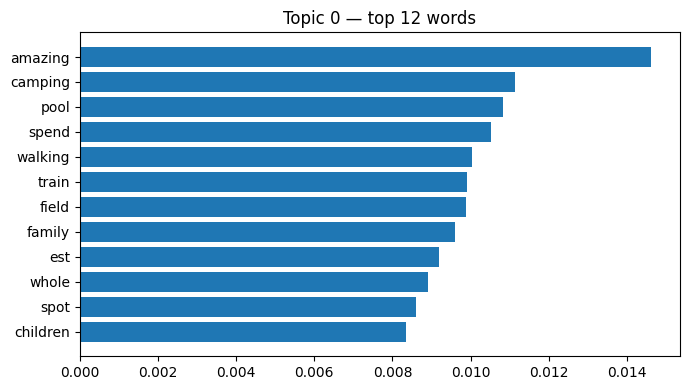

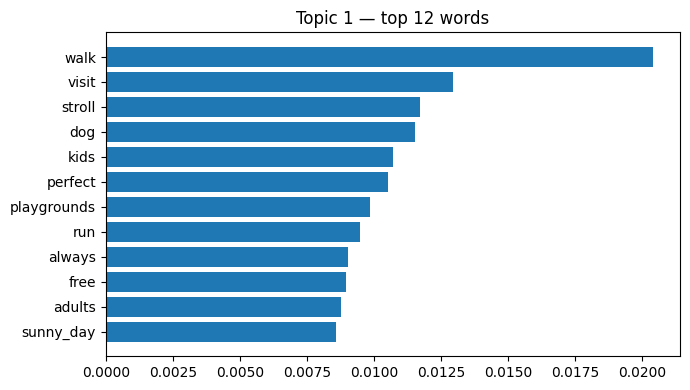

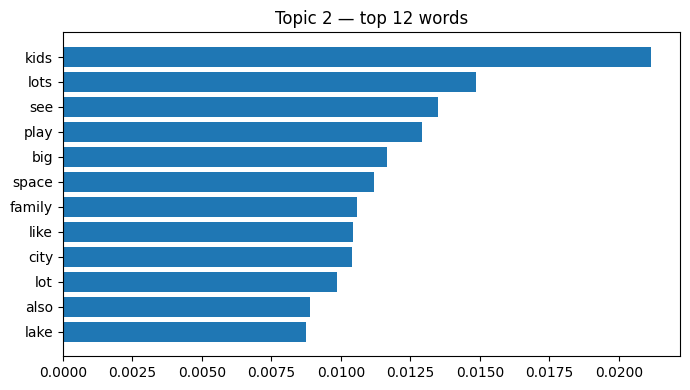

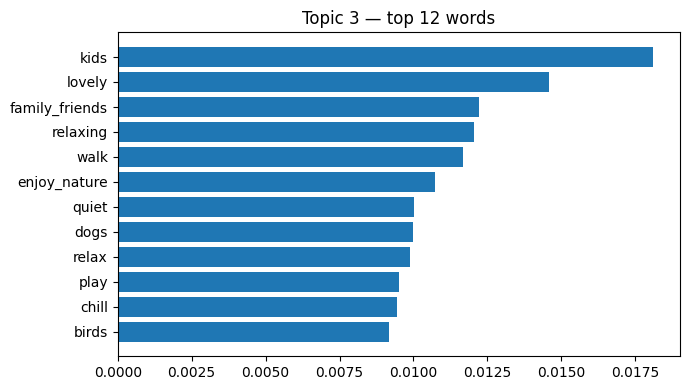

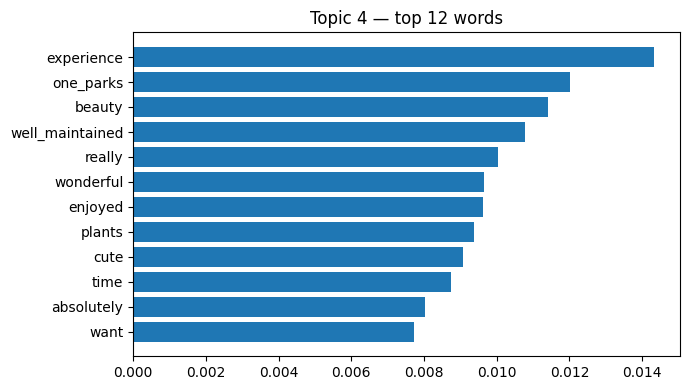

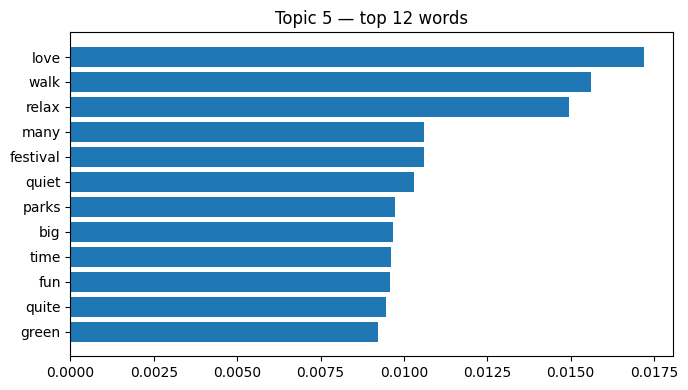

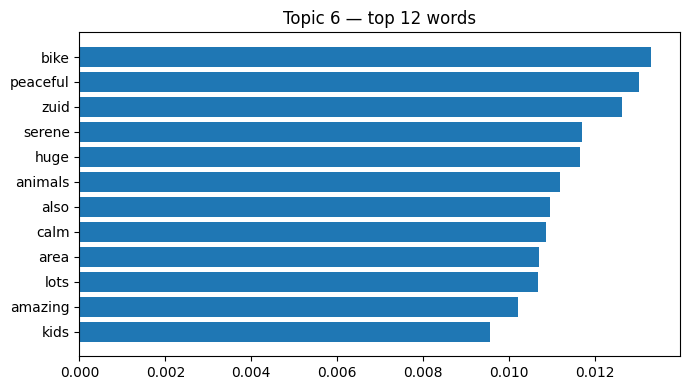

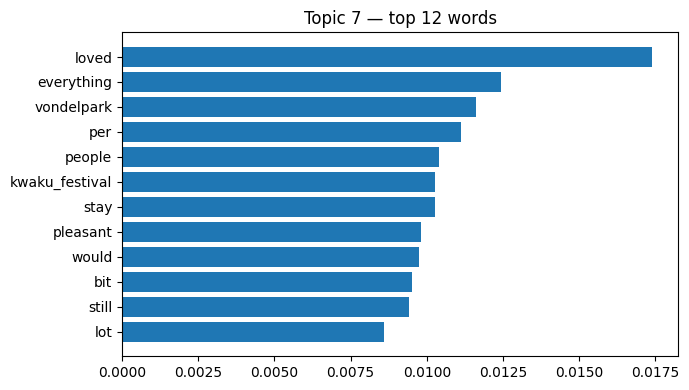


=== NL ===


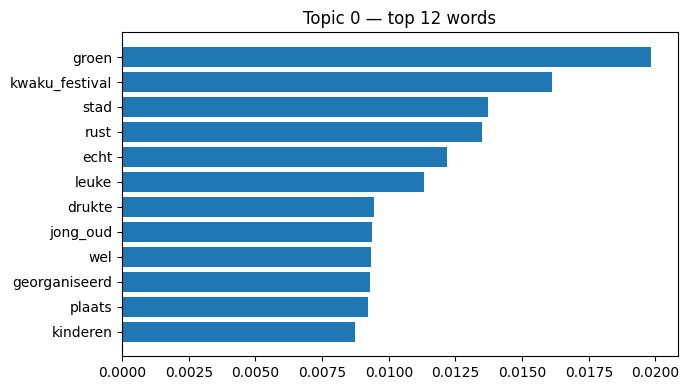

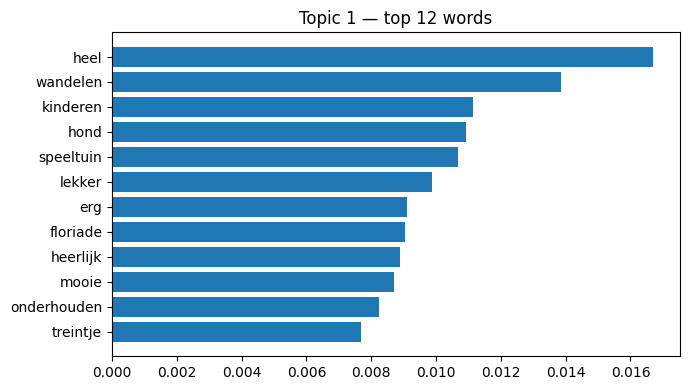

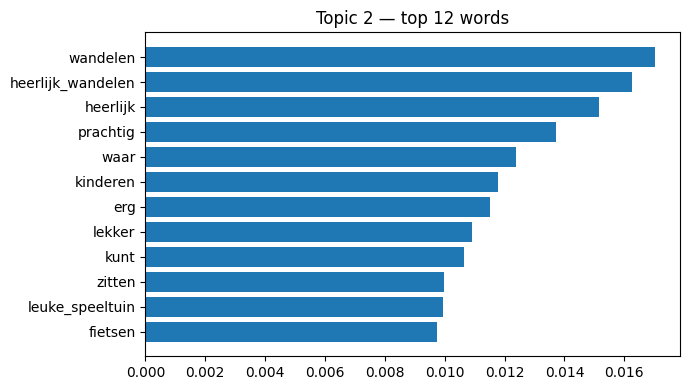

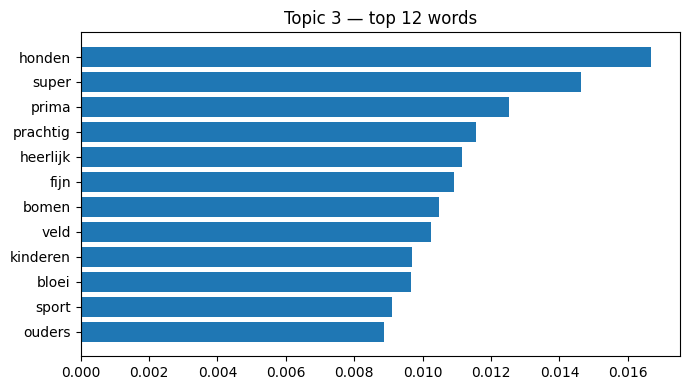

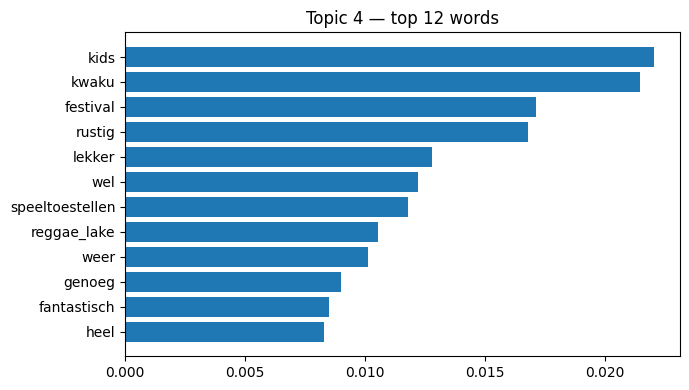

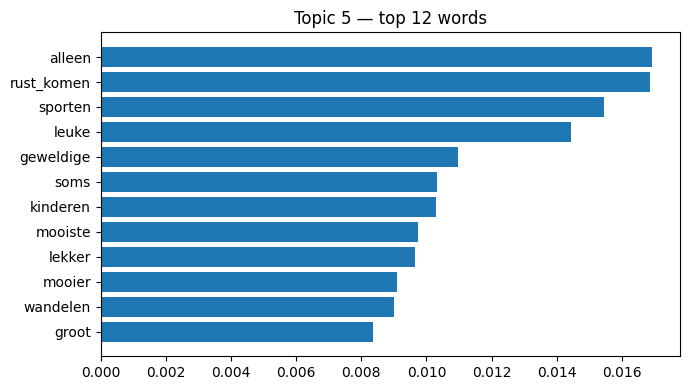

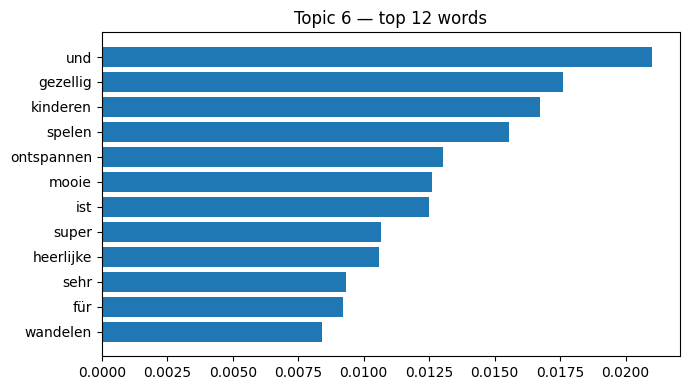

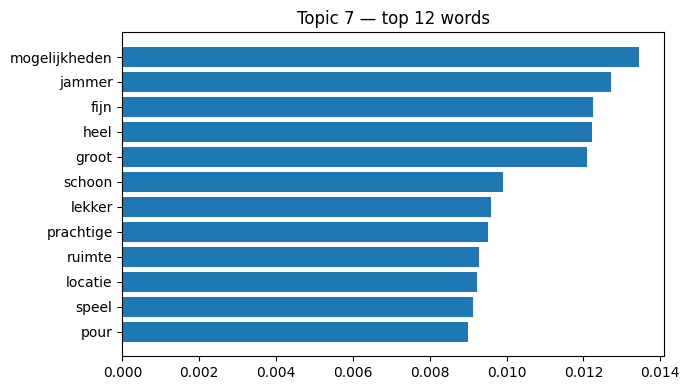

In [102]:
def plot_topic_bars(lda_model, topic_id, topn=12):
    pairs = lda_model.show_topic(topic_id, topn=topn)
    words = [w for w,_ in pairs][::-1]
    weights = [v for _,v in pairs][::-1]
    plt.figure(figsize=(7,4))
    plt.barh(words, weights)
    plt.title(f"Topic {topic_id} — top {topn} words")
    plt.tight_layout()
    plt.show()

for lang, obj in models.items():
    print("\n===", lang.upper(), "===")
    lda = obj["lda"]
    for t in range(lda.num_topics):
        plot_topic_bars(lda, t, topn=12)


In [103]:
import numpy as np
import pandas as pd

def doc_topic_matrix(lda, corpus, k):
    mat = np.zeros((len(corpus), k), dtype=float)
    for i, bow in enumerate(corpus):
        for topic_id, prob in lda.get_document_topics(bow, minimum_probability=0):
            mat[i, topic_id] = prob
    return mat

for lang, obj in models.items():
    lda = obj["lda"]
    k = lda.num_topics

    mat = doc_topic_matrix(lda, obj["corpus_bow"], k)
    mat_df = pd.DataFrame(mat, columns=[f"topic_{i}" for i in range(k)])

    doc_df = pd.concat([obj["df"].reset_index(drop=True), mat_df], axis=1)
    models[lang]["doc_topics_df"] = doc_df

    print(lang, "doc_topics_df shape:", doc_df.shape)

display(models["en"]["doc_topics_df"].head(3))


en doc_topics_df shape: (1774, 19)
nl doc_topics_df shape: (1992, 19)


,review_id,rating,text,language,date,park,park_key,lang,district,source_file,lang_detected,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,1,5.0,"I recently visited Amsterdam Park, and it was ...",en,2025-09-04,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.002173,0.306896,0.003007,0.192661,0.069376,0.158305,0.265614,0.001968
1,2,5.0,One of my most memorable moments in Amsterdam ...,en,2025-10-14,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.526792,0.079198,0.007006,0.366032,0.004919,0.005871,0.005600,0.004582
2,3,5.0,One of the best parks to walk and have fun wit...,en,2025-06-09,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.310522,0.264714,0.191532,0.127790,0.004057,0.092991,0.004617,0.003778


In [104]:
#tables
tables = []

for lang, obj in models.items():
    doc_df = obj["doc_topics_df"]
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]

    park_tbl = doc_df.groupby("park_key")[topic_cols].mean().reset_index()
    park_tbl.insert(0, "level", "park")
    park_tbl.insert(1, "lang", lang)
    tables.append(park_tbl)

    dist_tbl = doc_df.groupby("district")[topic_cols].mean().reset_index().rename(columns={"district":"group"})
    dist_tbl.insert(0, "level", "district")
    dist_tbl.insert(1, "lang", lang)
    dist_tbl = dist_tbl.rename(columns={"group":"park_key"})  # for district
    tables.append(dist_tbl)

prevalence_df = pd.concat(tables, ignore_index=True)
display(prevalence_df.head(10))


,level,lang,park_key,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,park,en,amstel,0.091963,0.146322,0.290455,0.084693,0.097240,0.116054,0.123445,0.049827
1,park,en,beatrix,0.105423,0.134563,0.168928,0.160599,0.068944,0.142638,0.134392,0.084513
2,park,en,gaasper,0.105472,0.138102,0.158774,0.098524,0.127739,0.151833,0.122534,0.097022
3,park,en,nelson,0.126339,0.081342,0.167875,0.101743,0.086465,0.208559,0.116439,0.111238
4,district,en,Zuid,0.098783,0.140364,0.228878,0.123155,0.082903,0.129524,0.128992,0.067402
5,district,en,Zuidoost,0.113777,0.115511,0.162397,0.099805,0.111311,0.174411,0.120108,0.102680
6,park,nl,amstel,0.091931,0.209493,0.233563,0.119771,0.081071,0.096941,0.070946,0.096283
7,park,nl,beatrix,0.106088,0.173325,0.170601,0.157082,0.110967,0.077321,0.102057,0.102561
8,park,nl,gaasper,0.095285,0.133723,0.138703,0.121874,0.109708,0.083496,0.201623,0.115588
9,park,nl,nelson,0.114943,0.137099,0.095547,0.094537,0.149460,0.153078,0.104065,0.151271


In [105]:
def top_topics_row(row, topn=3):
    topic_cols = [c for c in row.index if c.startswith("topic_")]
    pairs = sorted([(c, row[c]) for c in topic_cols], key=lambda x: x[1], reverse=True)[:topn]
    return "; ".join([f"{t} ({v:.2f})" for t,v in pairs])

summaries = []
for lang, obj in models.items():
    doc_df = obj["doc_topics_df"]
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]

    park_mean = doc_df.groupby("park_key")[topic_cols].mean()
    for park, row in park_mean.iterrows():
        summaries.append({"lang": lang, "level": "park", "group": park, "top_topics": top_topics_row(row)})

    dist_mean = doc_df.groupby("district")[topic_cols].mean()
    for dist, row in dist_mean.iterrows():
        summaries.append({"lang": lang, "level": "district", "group": dist, "top_topics": top_topics_row(row)})

summary_df = pd.DataFrame(summaries)
display(summary_df)


,lang,level,group,top_topics
0,en,park,amstel,topic_2 (0.29); topic_1 (0.15); topic_6 (0.12)
1,en,park,beatrix,topic_2 (0.17); topic_3 (0.16); topic_5 (0.14)
2,en,park,gaasper,topic_2 (0.16); topic_5 (0.15); topic_1 (0.14)
3,en,park,nelson,topic_5 (0.21); topic_2 (0.17); topic_0 (0.13)
4,en,district,Zuid,topic_2 (0.23); topic_1 (0.14); topic_5 (0.13)
5,en,district,Zuidoost,topic_5 (0.17); topic_2 (0.16); topic_6 (0.12)
6,nl,park,amstel,topic_2 (0.23); topic_1 (0.21); topic_3 (0.12)
7,nl,park,beatrix,topic_1 (0.17); topic_2 (0.17); topic_3 (0.16)
8,nl,park,gaasper,topic_6 (0.20); topic_2 (0.14); topic_1 (0.13)
9,nl,park,nelson,topic_5 (0.15); topic_7 (0.15); topic_4 (0.15)


Comparison:

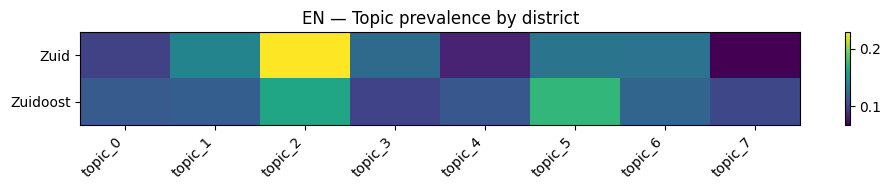

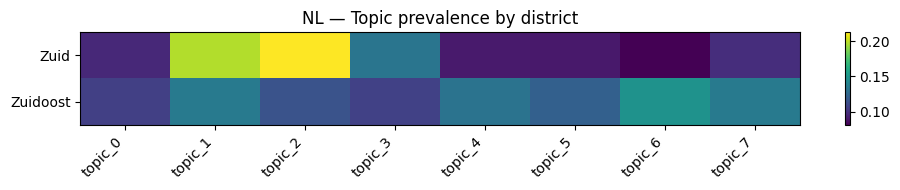

In [106]:
import matplotlib.pyplot as plt

def heatmap(df, title):
    groups = df.iloc[:,0].tolist()
    mat = df.iloc[:,1:].to_numpy()
    cols = df.columns[1:].tolist()

    plt.figure(figsize=(10, max(2, 0.8*len(groups))))
    plt.imshow(mat, aspect="auto")
    plt.yticks(range(len(groups)), groups)
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

for lang, obj in models.items():
    doc_df = obj["doc_topics_df"]
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]

    dist_tbl = doc_df.groupby("district")[topic_cols].mean().reset_index()
    heatmap(dist_tbl, f"{lang.upper()} — Topic prevalence by district")


In [107]:
def district_diff_table(doc_df, topn=8):
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]
    means = doc_df.groupby("district")[topic_cols].mean()

    if ("Zuid" not in means.index) or ("Zuidoost" not in means.index):
        return means

    diff = (means.loc["Zuid"] - means.loc["Zuidoost"]).sort_values(ascending=False)
    out = pd.DataFrame({
        "topic": diff.index,
        "Zuid_minus_Zuidoost": diff.values
    })
    return out.head(topn), out.tail(topn)

for lang, obj in models.items():
    print("\n", lang.upper())
    top_pos, top_neg = district_diff_table(obj["doc_topics_df"], topn=6)
    print("More in Zuid:")
    display(top_pos)
    print("More in Zuidoost:")
    display(top_neg)



 EN
More in Zuid:


,topic,Zuid_minus_Zuidoost
0,topic_2,0.066481
1,topic_1,0.024853
2,topic_3,0.023350
3,topic_6,0.008884
4,topic_0,-0.014994
5,topic_4,-0.028408


More in Zuidoost:


,topic,Zuid_minus_Zuidoost
2,topic_3,0.023350
3,topic_6,0.008884
4,topic_0,-0.014994
5,topic_4,-0.028408
6,topic_7,-0.035278
7,topic_5,-0.044887



 NL
More in Zuid:


,topic,Zuid_minus_Zuidoost
0,topic_2,0.097563
1,topic_1,0.061847
2,topic_3,0.025368
3,topic_0,-0.009432
4,topic_5,-0.031334
5,topic_7,-0.036817


More in Zuidoost:


,topic,Zuid_minus_Zuidoost
2,topic_3,0.025368
3,topic_0,-0.009432
4,topic_5,-0.031334
5,topic_7,-0.036817
6,topic_4,-0.040504
7,topic_6,-0.066692


In [108]:
import re

def make_topic_labels_from_topics_df(topics_df, n_words=5):

    out = {}
    for _, r in topics_df.iterrows():
        lang = str(r["lang"]).lower()
        tid = int(r["topic_id"])
        words = str(r["top_words"]).split(",")
        words = [w.strip() for w in words if w.strip()]
        label = ", ".join(words[:n_words])
        out.setdefault(lang, {})[tid] = label
    return out

TOPIC_LABELS = make_topic_labels_from_topics_df(topics_df, n_words=5)
TOPIC_LABELS


{'en': {0: 'amazing, camping, pool, spend, walking',
  1: 'walk, visit, stroll, dog, kids',
  2: 'kids, lots, see, play, big',
  3: 'kids, lovely, family_friends, relaxing, walk',
  4: 'experience, one_parks, beauty, well_maintained, really',
  5: 'love, walk, relax, many, festival',
  6: 'bike, peaceful, zuid, serene, huge',
  7: 'loved, everything, vondelpark, per, people'},
 'nl': {0: 'groen, kwaku_festival, stad, rust, echt',
  1: 'heel, wandelen, kinderen, hond, speeltuin',
  2: 'wandelen, heerlijk_wandelen, heerlijk, prachtig, waar',
  3: 'honden, super, prima, prachtig, heerlijk',
  4: 'kids, kwaku, festival, rustig, lekker',
  5: 'alleen, rust_komen, sporten, leuke, geweldige',
  6: 'und, gezellig, kinderen, spelen, ontspannen',
  7: 'mogelijkheden, jammer, fijn, heel, groot'}}

In [109]:
def rename_topic_cols(df, lang):
    df = df.copy()
    mapping = {}
    for c in df.columns:
        if c.startswith("topic_"):
            tid = int(c.split("_")[1])
            mapping[c] = TOPIC_LABELS.get(lang, {}).get(tid, c)
    return df.rename(columns=mapping)


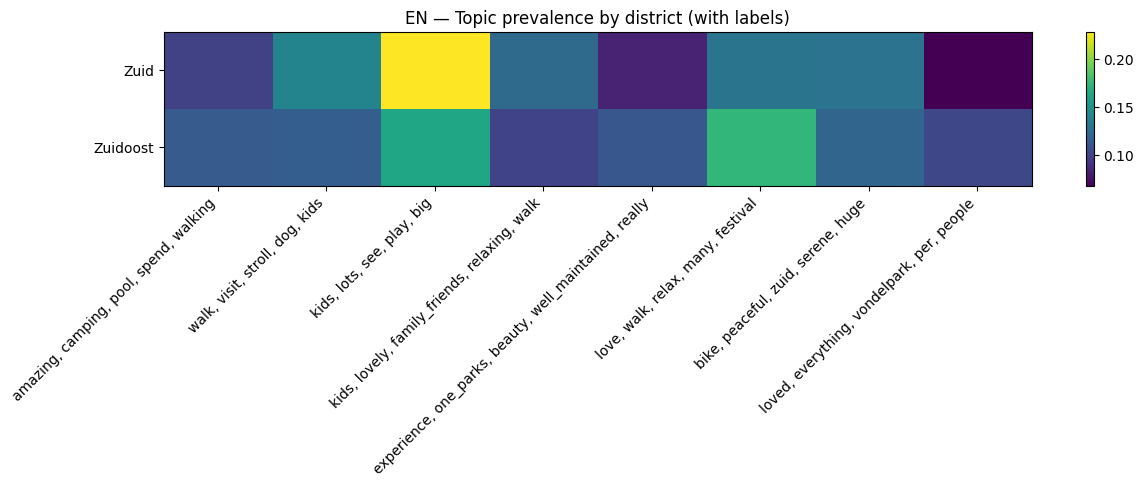

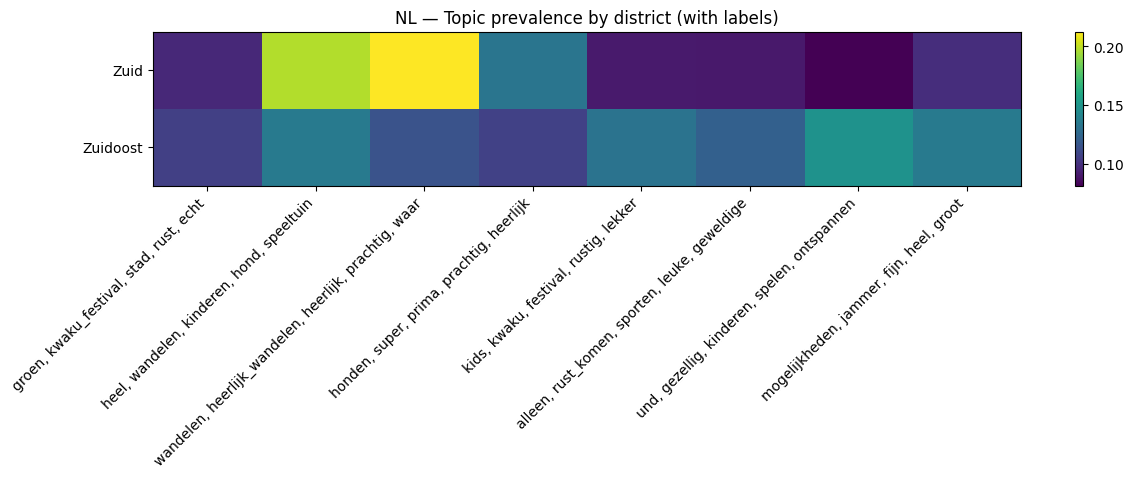

In [110]:
import matplotlib.pyplot as plt

def heatmap_labeled(df_level, lang, title):
    df2 = rename_topic_cols(df_level, lang)
    groups = df2.iloc[:,0].tolist()
    mat = df2.iloc[:,1:].to_numpy()
    cols = df2.columns[1:].tolist()

    plt.figure(figsize=(14, max(2, 0.8*len(groups))))
    plt.imshow(mat, aspect="auto")
    plt.yticks(range(len(groups)), groups)
    plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

for lang, obj in models.items():
    doc_df = obj["doc_topics_df"]
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]
    dist_tbl = doc_df.groupby("district")[topic_cols].mean().reset_index()
    heatmap_labeled(dist_tbl, lang, f"{lang.upper()} — Topic prevalence by district (with labels)")


Comparison for rating (no success):

In [111]:
RATING_COL = "rating"  
LOW_THR = 2
HIGH_THR = 4

def negative_topics_by_district(doc_df, lang):
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]
    df = doc_df.dropna(subset=[RATING_COL]).copy()


    df["bucket"] = np.where(df[RATING_COL] <= LOW_THR, "low",
                     np.where(df[RATING_COL] >= HIGH_THR, "high", "mid"))
    df = df[df["bucket"].isin(["low","high"])]


    means = df.groupby(["district","bucket"])[topic_cols].mean()


    rows = []
    for dist in means.index.get_level_values(0).unique():
        if (dist, "low") in means.index and (dist, "high") in means.index:
            diff = (means.loc[(dist,"low")] - means.loc[(dist,"high")]).sort_values(ascending=False)
            for t, v in diff.items():
                rows.append({
                    "lang": lang,
                    "district": dist,
                    "topic": t,
                    "low_minus_high": float(v)
                })
    out = pd.DataFrame(rows).sort_values(["lang","district","low_minus_high"], ascending=[True,True,False])
    return out

neg_tables = []
for lang, obj in models.items():
    df_doc = obj["doc_topics_df"]
    if RATING_COL in df_doc.columns:
        neg_tables.append(negative_topics_by_district(df_doc, lang))

neg_df = pd.concat(neg_tables, ignore_index=True) if neg_tables else pd.DataFrame()
display(neg_df.head(30))


,lang,district,topic,low_minus_high
0,en,Zuid,topic_1,0.395228
1,en,Zuid,topic_2,0.093133
2,en,Zuid,topic_7,-0.051510
3,en,Zuid,topic_5,-0.065405
4,en,Zuid,topic_4,-0.066373
5,en,Zuid,topic_0,-0.083692
6,en,Zuid,topic_3,-0.108580
7,en,Zuid,topic_6,-0.112801
8,en,Zuidoost,topic_7,0.122760
9,en,Zuidoost,topic_4,0.104853


In [112]:
def top_neg(neg_df, lang, district, topn=5):
    sub = neg_df[(neg_df["lang"]==lang) & (neg_df["district"]==district)].head(topn)
    return sub

for lang in models.keys():
    print("\n", lang.upper(), "Zuid (most negative-associated topics):")
    display(top_neg(neg_df, lang, "Zuid", topn=6))
    print(lang.upper(), "Zuidoost (most negative-associated topics):")
    display(top_neg(neg_df, lang, "Zuidoost", topn=6))



 EN Zuid (most negative-associated topics):


,lang,district,topic,low_minus_high
0,en,Zuid,topic_1,0.395228
1,en,Zuid,topic_2,0.093133
2,en,Zuid,topic_7,-0.051510
3,en,Zuid,topic_5,-0.065405
4,en,Zuid,topic_4,-0.066373
5,en,Zuid,topic_0,-0.083692


EN Zuidoost (most negative-associated topics):


,lang,district,topic,low_minus_high
8,en,Zuidoost,topic_7,0.122760
9,en,Zuidoost,topic_4,0.104853
10,en,Zuidoost,topic_6,0.029413
11,en,Zuidoost,topic_0,0.012562
12,en,Zuidoost,topic_1,-0.013389
13,en,Zuidoost,topic_3,-0.057739



 NL Zuid (most negative-associated topics):


,lang,district,topic,low_minus_high
16,nl,Zuid,topic_5,0.092410
17,nl,Zuid,topic_3,0.056775
18,nl,Zuid,topic_0,0.046189
19,nl,Zuid,topic_7,0.032453
20,nl,Zuid,topic_4,0.024849
21,nl,Zuid,topic_6,-0.054863


NL Zuidoost (most negative-associated topics):


,lang,district,topic,low_minus_high
24,nl,Zuidoost,topic_5,0.141348
25,nl,Zuidoost,topic_0,0.024912
26,nl,Zuidoost,topic_4,0.023424
27,nl,Zuidoost,topic_3,0.006054
28,nl,Zuidoost,topic_1,-0.013728
29,nl,Zuidoost,topic_7,-0.036571


In [113]:
def label_topic(topic_col, lang):

    tid = int(topic_col.split("_")[1])
    return TOPIC_LABELS[lang].get(tid, topic_col)

neg_df_labeled = neg_df.copy()
neg_df_labeled["topic_label"] = neg_df_labeled.apply(lambda r: label_topic(r["topic"], r["lang"]), axis=1)
display(neg_df_labeled.head(30))


,lang,district,topic,low_minus_high,topic_label
0,en,Zuid,topic_1,0.395228,"walk, visit, stroll, dog, kids"
1,en,Zuid,topic_2,0.093133,"kids, lots, see, play, big"
2,en,Zuid,topic_7,-0.051510,"loved, everything, vondelpark, per, people"
3,en,Zuid,topic_5,-0.065405,"love, walk, relax, many, festival"
4,en,Zuid,topic_4,-0.066373,"experience, one_parks, beauty, well_maintained..."
5,en,Zuid,topic_0,-0.083692,"amazing, camping, pool, spend, walking"
6,en,Zuid,topic_3,-0.108580,"kids, lovely, family_friends, relaxing, walk"
7,en,Zuid,topic_6,-0.112801,"bike, peaceful, zuid, serene, huge"
8,en,Zuidoost,topic_7,0.122760,"loved, everything, vondelpark, per, people"
9,en,Zuidoost,topic_4,0.104853,"experience, one_parks, beauty, well_maintained..."


In [114]:
#here I tried with more mixed reviews 
RATING_COL = "rating"
LOW_THR = 3
HIGH_THR = 4

df_r = data_filt.copy()
df_r[RATING_COL] = pd.to_numeric(df_r[RATING_COL], errors="coerce")
df_r = df_r.dropna(subset=[RATING_COL])

df_r["bucket"] = np.where(df_r[RATING_COL] <= LOW_THR, "low",
                   np.where(df_r[RATING_COL] >= HIGH_THR, "high", "mid"))

display(df_r["bucket"].value_counts())
display(df_r.groupby(["lang","district","bucket"]).size().reset_index(name="n"))


bucket
high    3468
low      298
Name: count, dtype: int64

,lang,district,bucket,n
0,en,Zuid,high,1218
1,en,Zuid,low,51
2,en,Zuidoost,high,453
3,en,Zuidoost,low,52
4,nl,Zuid,high,906
5,nl,Zuid,low,65
6,nl,Zuidoost,high,891
7,nl,Zuidoost,low,130


In [115]:

KEY_COL = "review_id" if "review_id" in df_r.columns else None

if KEY_COL is None:

    df_r["__key"] = df_r["source_file"].astype(str) + "||" + df_r[TEXT_COL].astype(str)
    KEY_COL = "__key"

doc_models = {}

for lang, obj in models.items():
    doc_df = obj["doc_topics_df"].copy()
    doc_df[RATING_COL] = pd.to_numeric(doc_df[RATING_COL], errors="coerce")

    if KEY_COL == "__key":
        doc_df["__key"] = doc_df["source_file"].astype(str) + "||" + doc_df[TEXT_COL].astype(str)


    merged = doc_df.merge(df_r[[KEY_COL, "bucket"]], on=KEY_COL, how="inner")

    doc_models[lang] = merged
    print(lang, "after merge:", merged.shape)

display(doc_models["en"].head(3))


en after merge: (9627, 20)
nl after merge: (10577, 20)


,review_id,rating,text,language,date,park,park_key,lang,district,source_file,lang_detected,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,bucket
0,1,5.0,"I recently visited Amsterdam Park, and it was ...",en,2025-09-04,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.002173,0.306896,0.003007,0.192661,0.069376,0.158305,0.265614,0.001968,high
1,1,5.0,"I recently visited Amsterdam Park, and it was ...",en,2025-09-04,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.002173,0.306896,0.003007,0.192661,0.069376,0.158305,0.265614,0.001968,high
2,1,5.0,"I recently visited Amsterdam Park, and it was ...",en,2025-09-04,Amstelpark,amstel,en,Zuid,amstel_en_clean.csv,en,0.002173,0.306896,0.003007,0.192661,0.069376,0.158305,0.265614,0.001968,high


In [116]:
def prevalence_by_group(df_doc, group_col):
    topic_cols = [c for c in df_doc.columns if c.startswith("topic_")]
    return df_doc.groupby([group_col, "bucket"])[topic_cols].mean().reset_index()

dist_tables = []
for lang, d in doc_models.items():
    t = prevalence_by_group(d, "district")
    t.insert(0, "lang", lang)
    dist_tables.append(t)

dist_prev_bucket = pd.concat(dist_tables, ignore_index=True)
display(dist_prev_bucket.head(12))


,lang,district,bucket,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,en,Zuid,high,0.099234,0.141911,0.232675,0.120031,0.082910,0.128695,0.128510,0.066035
1,en,Zuid,low,0.095666,0.138628,0.227300,0.143955,0.086535,0.114723,0.125262,0.067930
2,en,Zuidoost,high,0.109566,0.114371,0.168017,0.099152,0.113125,0.177989,0.121379,0.096402
3,en,Zuidoost,low,0.130868,0.129628,0.140264,0.106963,0.122801,0.158537,0.110445,0.100493
4,nl,Zuid,high,0.093799,0.197118,0.211282,0.138350,0.091738,0.088809,0.080072,0.098833
5,nl,Zuid,low,0.100215,0.183987,0.213649,0.122580,0.094907,0.099622,0.088215,0.096825
6,nl,Zuidoost,high,0.107770,0.136167,0.116900,0.109913,0.129716,0.120023,0.143725,0.135787
7,nl,Zuidoost,low,0.098855,0.125190,0.136447,0.099126,0.163009,0.140614,0.120744,0.116015


In [117]:
def delta_two_groups(df_level, group_a="Zuid", group_b="Zuidoost"):
    topic_cols = [c for c in df_level.columns if c.startswith("topic_")]
    a = df_level[df_level["district"]==group_a].set_index("bucket")[topic_cols]
    b = df_level[df_level["district"]==group_b].set_index("bucket")[topic_cols]
    common = a.index.intersection(b.index)
    out = []
    for bucket in common:
        diff = (a.loc[bucket] - b.loc[bucket]).sort_values(ascending=False)
        for t, v in diff.items():
            out.append({"bucket": bucket, "topic": t, "Zuid_minus_Zuidoost": float(v)})
    return pd.DataFrame(out)

delta_tables = []
for lang in doc_models.keys():
    sub = dist_prev_bucket[dist_prev_bucket["lang"]==lang].rename(columns={"district":"district"})
 
    out = delta_two_groups(sub, "Zuid", "Zuidoost")
    out.insert(0, "lang", lang)
    delta_tables.append(out)

delta_df = pd.concat(delta_tables, ignore_index=True)


for lang in doc_models.keys():
    print("\n", lang.upper(), "LOW (Zuid - Zuidoost):")
    display(delta_df[(delta_df["lang"]==lang) & (delta_df["bucket"]=="low")].head(8))
    print(lang.upper(), "HIGH (Zuid - Zuidoost):")
    display(delta_df[(delta_df["lang"]==lang) & (delta_df["bucket"]=="high")].head(8))



 EN LOW (Zuid - Zuidoost):


,lang,bucket,topic,Zuid_minus_Zuidoost
8,en,low,topic_2,0.087036
9,en,low,topic_3,0.036993
10,en,low,topic_6,0.014817
11,en,low,topic_1,0.008999
12,en,low,topic_7,-0.032563
13,en,low,topic_0,-0.035201
14,en,low,topic_4,-0.036266
15,en,low,topic_5,-0.043814


EN HIGH (Zuid - Zuidoost):


,lang,bucket,topic,Zuid_minus_Zuidoost
0,en,high,topic_2,0.064658
1,en,high,topic_1,0.027540
2,en,high,topic_3,0.020879
3,en,high,topic_6,0.007131
4,en,high,topic_0,-0.010332
5,en,high,topic_4,-0.030215
6,en,high,topic_7,-0.030367
7,en,high,topic_5,-0.049295



 NL LOW (Zuid - Zuidoost):


,lang,bucket,topic,Zuid_minus_Zuidoost
24,nl,low,topic_2,0.077202
25,nl,low,topic_1,0.058796
26,nl,low,topic_3,0.023454
27,nl,low,topic_0,0.001360
28,nl,low,topic_7,-0.019189
29,nl,low,topic_6,-0.032529
30,nl,low,topic_5,-0.040992
31,nl,low,topic_4,-0.068102


NL HIGH (Zuid - Zuidoost):


,lang,bucket,topic,Zuid_minus_Zuidoost
16,nl,high,topic_2,0.094382
17,nl,high,topic_1,0.060951
18,nl,high,topic_3,0.028436
19,nl,high,topic_0,-0.013971
20,nl,high,topic_5,-0.031214
21,nl,high,topic_7,-0.036953
22,nl,high,topic_4,-0.037978
23,nl,high,topic_6,-0.063653


In [118]:
def make_topic_labels_from_topics_df(topics_df, n_words=5):
    out = {}
    for _, r in topics_df.iterrows():
        lang = str(r["lang"]).lower()
        tid = int(r["topic_id"])
        words = [w.strip() for w in str(r["top_words"]).split(",") if w.strip()]
        out.setdefault(lang, {})[tid] = ", ".join(words[:n_words])
    return out

TOPIC_LABELS = make_topic_labels_from_topics_df(topics_df, n_words=5)

def label_topic(topic_col, lang):
    tid = int(topic_col.split("_")[1])
    return TOPIC_LABELS[lang].get(tid, topic_col)

delta_df["topic_label"] = delta_df.apply(lambda r: label_topic(r["topic"], r["lang"]), axis=1)

for lang in doc_models.keys():
    print("\n", lang.upper(), "LOW labeled:")
    display(delta_df[(delta_df["lang"]==lang) & (delta_df["bucket"]=="low")][["topic_label","Zuid_minus_Zuidoost"]].head(10))



 EN LOW labeled:


,topic_label,Zuid_minus_Zuidoost
8,"kids, lots, see, play, big",0.087036
9,"kids, lovely, family_friends, relaxing, walk",0.036993
10,"bike, peaceful, zuid, serene, huge",0.014817
11,"walk, visit, stroll, dog, kids",0.008999
12,"loved, everything, vondelpark, per, people",-0.032563
13,"amazing, camping, pool, spend, walking",-0.035201
14,"experience, one_parks, beauty, well_maintained...",-0.036266
15,"love, walk, relax, many, festival",-0.043814



 NL LOW labeled:


,topic_label,Zuid_minus_Zuidoost
24,"wandelen, heerlijk_wandelen, heerlijk, prachti...",0.077202
25,"heel, wandelen, kinderen, hond, speeltuin",0.058796
26,"honden, super, prima, prachtig, heerlijk",0.023454
27,"groen, kwaku_festival, stad, rust, echt",0.001360
28,"mogelijkheden, jammer, fijn, heel, groot",-0.019189
29,"und, gezellig, kinderen, spelen, ontspannen",-0.032529
30,"alleen, rust_komen, sporten, leuke, geweldige",-0.040992
31,"kids, kwaku, festival, rustig, lekker",-0.068102


In [119]:
park_tables = []
for lang, d in doc_models.items():
    topic_cols = [c for c in d.columns if c.startswith("topic_")]
    park_prev = d.groupby(["park_key","bucket"])[topic_cols].mean().reset_index()
    park_prev.insert(0, "lang", lang)
    park_tables.append(park_prev)

park_prev_bucket = pd.concat(park_tables, ignore_index=True)
display(park_prev_bucket.head(10))


,lang,park_key,bucket,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,en,amstel,high,0.093367,0.148045,0.293718,0.083663,0.097803,0.113546,0.122651,0.047208
1,en,amstel,low,0.091887,0.142354,0.294472,0.094076,0.091865,0.114844,0.117949,0.052552
2,en,beatrix,high,0.104907,0.135980,0.173647,0.155198,0.068508,0.143343,0.134175,0.084240
3,en,beatrix,low,0.099505,0.134842,0.159053,0.194632,0.081121,0.114601,0.132692,0.083554
4,en,gaasper,high,0.099136,0.140790,0.161757,0.097754,0.135244,0.152879,0.127152,0.085288
5,en,gaasper,low,0.127626,0.155352,0.150756,0.115744,0.136544,0.151321,0.090262,0.072395
6,en,nelson,high,0.124174,0.077371,0.176784,0.101109,0.082147,0.213156,0.113293,0.111967
7,en,nelson,low,0.135305,0.094414,0.125902,0.094941,0.103989,0.168416,0.138074,0.138958
8,nl,amstel,high,0.087819,0.212845,0.235804,0.124869,0.078944,0.097314,0.067197,0.095207
9,nl,amstel,low,0.101333,0.195221,0.232919,0.106309,0.085159,0.102109,0.083291,0.093659


In [120]:
#it doesnt make a lot of sence
def low_high_diff_by_district(doc_df, lang):
    topic_cols = [c for c in doc_df.columns if c.startswith("topic_")]
    m = doc_df.groupby(["district","bucket"])[topic_cols].mean()

    rows = []
    for dist in m.index.get_level_values(0).unique():
        if (dist,"low") in m.index and (dist,"high") in m.index:
            diff = (m.loc[(dist,"low")] - m.loc[(dist,"high")]).sort_values(ascending=False)
            for t, v in diff.items():
                rows.append({
                    "lang": lang,
                    "district": dist,
                    "topic": t,
                    "low_minus_high": float(v)
                })
    return pd.DataFrame(rows).sort_values(["lang","district","low_minus_high"], ascending=[True,True,False])

true_neg_tables = []
for lang, d in doc_models.items():  
    true_neg_tables.append(low_high_diff_by_district(d, lang))

true_neg_df = pd.concat(true_neg_tables, ignore_index=True)


true_neg_df["topic_label"] = true_neg_df.apply(lambda r: label_topic(r["topic"], r["lang"]), axis=1)

for lang in doc_models.keys():
    print("\n", lang.upper(), "Zuid — topics associated with LOW ratings (low-high):")
    display(true_neg_df[(true_neg_df["lang"]==lang) & (true_neg_df["district"]=="Zuid")][["topic_label","low_minus_high"]].head(8))
    print(lang.upper(), "Zuidoost — topics associated with LOW ratings (low-high):")
    display(true_neg_df[(true_neg_df["lang"]==lang) & (true_neg_df["district"]=="Zuidoost")][["topic_label","low_minus_high"]].head(8))



 EN Zuid — topics associated with LOW ratings (low-high):


,topic_label,low_minus_high
0,"kids, lovely, family_friends, relaxing, walk",0.023925
1,"experience, one_parks, beauty, well_maintained...",0.003626
2,"loved, everything, vondelpark, per, people",0.001896
3,"bike, peaceful, zuid, serene, huge",-0.003248
4,"walk, visit, stroll, dog, kids",-0.003284
5,"amazing, camping, pool, spend, walking",-0.003568
6,"kids, lots, see, play, big",-0.005375
7,"love, walk, relax, many, festival",-0.013971


EN Zuidoost — topics associated with LOW ratings (low-high):


,topic_label,low_minus_high
8,"amazing, camping, pool, spend, walking",0.021302
9,"walk, visit, stroll, dog, kids",0.015257
10,"experience, one_parks, beauty, well_maintained...",0.009676
11,"kids, lovely, family_friends, relaxing, walk",0.007811
12,"loved, everything, vondelpark, per, people",0.004091
13,"bike, peaceful, zuid, serene, huge",-0.010933
14,"love, walk, relax, many, festival",-0.019452
15,"kids, lots, see, play, big",-0.027752



 NL Zuid — topics associated with LOW ratings (low-high):


,topic_label,low_minus_high
16,"alleen, rust_komen, sporten, leuke, geweldige",0.010813
17,"und, gezellig, kinderen, spelen, ontspannen",0.008143
18,"groen, kwaku_festival, stad, rust, echt",0.006416
19,"kids, kwaku, festival, rustig, lekker",0.003169
20,"wandelen, heerlijk_wandelen, heerlijk, prachti...",0.002367
21,"mogelijkheden, jammer, fijn, heel, groot",-0.002008
22,"heel, wandelen, kinderen, hond, speeltuin",-0.013131
23,"honden, super, prima, prachtig, heerlijk",-0.015769


NL Zuidoost — topics associated with LOW ratings (low-high):


,topic_label,low_minus_high
24,"kids, kwaku, festival, rustig, lekker",0.033293
25,"alleen, rust_komen, sporten, leuke, geweldige",0.020591
26,"wandelen, heerlijk_wandelen, heerlijk, prachti...",0.019547
27,"groen, kwaku_festival, stad, rust, echt",-0.008915
28,"honden, super, prima, prachtig, heerlijk",-0.010787
29,"heel, wandelen, kinderen, hond, speeltuin",-0.010976
30,"mogelijkheden, jammer, fijn, heel, groot",-0.019772
31,"und, gezellig, kinderen, spelen, ontspannen",-0.022981


In [121]:
def compare_districts_on_neg(true_neg_df, lang):
    sub = true_neg_df[true_neg_df["lang"]==lang].copy()
    pivot = sub.pivot(index="topic", columns="district", values="low_minus_high").fillna(0)
    if "Zuid" in pivot.columns and "Zuidoost" in pivot.columns:
        pivot["Zuid_minus_Zuidoost_negdriver"] = pivot["Zuid"] - pivot["Zuidoost"]
    out = pivot.reset_index()
    out["topic_label"] = out["topic"].apply(lambda t: label_topic(t, lang))
    return out.sort_values("Zuid_minus_Zuidoost_negdriver", ascending=False)

for lang in doc_models.keys():
    print("\n", lang.upper(), "district comparison on NEG drivers (low-high):")
    display(compare_districts_on_neg(true_neg_df, lang)[["topic_label","Zuid_minus_Zuidoost_negdriver"]].head(12))



 EN district comparison on NEG drivers (low-high):


district,topic_label,Zuid_minus_Zuidoost_negdriver
2,"kids, lots, see, play, big",0.022377
3,"kids, lovely, family_friends, relaxing, walk",0.016114
6,"bike, peaceful, zuid, serene, huge",0.007686
5,"love, walk, relax, many, festival",0.005480
7,"loved, everything, vondelpark, per, people",-0.002196
4,"experience, one_parks, beauty, well_maintained...",-0.006051
1,"walk, visit, stroll, dog, kids",-0.018541
0,"amazing, camping, pool, spend, walking",-0.024869



 NL district comparison on NEG drivers (low-high):


district,topic_label,Zuid_minus_Zuidoost_negdriver
6,"und, gezellig, kinderen, spelen, ontspannen",0.031124
7,"mogelijkheden, jammer, fijn, heel, groot",0.017764
0,"groen, kwaku_festival, stad, rust, echt",0.015331
1,"heel, wandelen, kinderen, hond, speeltuin",-0.002155
3,"honden, super, prima, prachtig, heerlijk",-0.004982
5,"alleen, rust_komen, sporten, leuke, geweldige",-0.009779
2,"wandelen, heerlijk_wandelen, heerlijk, prachti...",-0.017180
4,"kids, kwaku, festival, rustig, lekker",-0.030124


Keyness (log-odds) with rating to see which words are assosiated with positive and which with negative ()

In [122]:
import numpy as np
import pandas as pd
from collections import Counter
import math

RATING_COL = "rating"
LOW_THR = 3
HIGH_THR = 4

def bucketize_rating(s):
    if pd.isna(s): return "na"
    if s <= LOW_THR: return "low"
    if s >= HIGH_THR: return "high"
    return "mid"


def tokens_basic(text, lang):
    toks = tokenize(text)
    stop = STOP_EN if lang=="en" else STOP_NL
    return [w for w in toks if (w not in stop) and (len(w) >= 3)]

def log_odds_dirichlet(counts_a, counts_b, alpha=0.01):
 
    vocab = set(counts_a) | set(counts_b)
 
    total = Counter()
    total.update(counts_a)
    total.update(counts_b)

    n_a = sum(counts_a.values())
    n_b = sum(counts_b.values())

    rows = []
    for w in vocab:
        a = counts_a.get(w, 0)
        b = counts_b.get(w, 0)
        prior = total.get(w, 0)

        a_tilde = a + alpha * prior + alpha
        b_tilde = b + alpha * prior + alpha

        n_a_tilde = n_a + alpha * sum(total.values()) + alpha * len(vocab)
        n_b_tilde = n_b + alpha * sum(total.values()) + alpha * len(vocab)

        logit_a = math.log(a_tilde / (n_a_tilde - a_tilde))
        logit_b = math.log(b_tilde / (n_b_tilde - b_tilde))
        delta = logit_a - logit_b

        var = 1/(a_tilde) + 1/(b_tilde)
        z = delta / math.sqrt(var)

        rows.append((w, z, a, b))
    return pd.DataFrame(rows, columns=["word","z","count_low","count_high"]).sort_values("z", ascending=False)


df_k = data_filt.copy()
df_k[RATING_COL] = pd.to_numeric(df_k[RATING_COL], errors="coerce")
df_k = df_k.dropna(subset=[RATING_COL])
df_k["bucket"] = df_k[RATING_COL].apply(bucketize_rating)
df_k = df_k[df_k["bucket"].isin(["low","high"])].copy()


reports = []
for (lang, district), sub in df_k.groupby(["lang","district"]):
    low_texts = sub[sub["bucket"]=="low"][TEXT_COL].astype(str).tolist()
    high_texts = sub[sub["bucket"]=="high"][TEXT_COL].astype(str).tolist()

    low_counts = Counter([w for t in low_texts for w in tokens_basic(t, lang)])
    high_counts = Counter([w for t in high_texts for w in tokens_basic(t, lang)])


    if sum(low_counts.values()) < 200 or sum(high_counts.values()) < 200:
        print("Too little data for", lang, district, "low/high tokens:", sum(low_counts.values()), sum(high_counts.values()))
        continue

    zdf = log_odds_dirichlet(low_counts, high_counts, alpha=0.01).head(20)
    zdf.insert(0, "district", district)
    zdf.insert(0, "lang", lang)
    reports.append(zdf)

keyness_low = pd.concat(reports, ignore_index=True) if reports else pd.DataFrame()
display(keyness_low)


,lang,district,word,z,count_low,count_high
0,en,Zuid,seem,4.030317,4,1
1,en,Zuid,statue,3.670522,3,4
2,en,Zuid,features,3.670522,3,4
3,en,Zuid,bus,3.539588,3,5
4,en,Zuid,many,3.164177,9,70
...,...,...,...,...,...,...
75,nl,Zuidoost,bier,3.304532,6,6
76,nl,Zuidoost,staat,3.236363,5,1
77,nl,Zuidoost,eten,3.175678,18,52
78,nl,Zuidoost,valt,3.174111,5,4


In [123]:
def keyness_between_groups(df, lang, district_a="Zuid", district_b="Zuidoost"):
    sub = df[(df["lang"]==lang) & (df["bucket"]=="low")].copy()
    a_texts = sub[sub["district"]==district_a][TEXT_COL].astype(str).tolist()
    b_texts = sub[sub["district"]==district_b][TEXT_COL].astype(str).tolist()

    a_counts = Counter([w for t in a_texts for w in tokens_basic(t, lang)])
    b_counts = Counter([w for t in b_texts for w in tokens_basic(t, lang)])

    zdf = log_odds_dirichlet(a_counts, b_counts, alpha=0.01).head(25)
    zdf["meaning"] = f"{district_a} LOW vs {district_b} LOW (positive=z in {district_a})"
    return zdf

for lang in ["en","nl"]:
    print("\n", lang.upper(), "LOW Zuid vs LOW Zuidoost")
    display(keyness_between_groups(df_k, lang))



 EN LOW Zuid vs LOW Zuidoost


,word,z,count_low,count_high,meaning
674,park,3.058593,38,23,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
272,beautiful,2.500897,10,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
393,many,2.289589,9,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
512,nice,2.194387,20,12,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
542,needs,1.926180,6,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
291,dog,1.727198,5,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
697,places,1.727198,5,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
350,bit,1.488229,4,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
131,children,1.488229,4,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
293,much,1.488229,4,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)



 NL LOW Zuid vs LOW Zuidoost


,word,z,count_low,count_high,meaning
471,mensen,3.287004,14,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
266,tijd,2.613397,10,3,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
977,prima,2.589264,9,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
468,park,2.128141,47,52,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
316,kinderen,2.019704,12,8,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
786,komen,1.973270,6,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
69,plek,1.711309,7,4,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
656,lopen,1.706144,5,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
243,moeten,1.706144,5,2,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)
18,zomer,1.699826,4,1,Zuid LOW vs Zuidoost LOW (positive=z in Zuid)


In [124]:
from collections import Counter
import pandas as pd
import math
import numpy as np

RATING_COL = "rating"
LOW_THR = 2
HIGH_THR = 4

def bucketize_rating(x):
    if pd.isna(x): return "na"
    if x <= LOW_THR: return "low"
    if x >= HIGH_THR: return "high"
    return "mid"


MINI_DOMAIN_STOP = {
    "en": {"park","amsterdam","place","nice","good","great","best"},
    "nl": {"park","amsterdam","plek","mooi","goed","leuk","geweldig"},
}

def tokens_basic(text, lang):
    toks = tokenize(text)
    stop = STOP_EN if lang=="en" else STOP_NL
    dom = MINI_DOMAIN_STOP[lang]
    return [w for w in toks if (w not in stop) and (w not in dom) and (len(w) >= 3)]

def log_odds_z(counts_a, counts_b, alpha=0.01):
    vocab = set(counts_a) | set(counts_b)
    total = Counter(); total.update(counts_a); total.update(counts_b)
    n_a = sum(counts_a.values()); n_b = sum(counts_b.values())
    sum_total = sum(total.values())
    V = len(vocab)

    rows = []
    for w in vocab:
        a = counts_a.get(w, 0)
        b = counts_b.get(w, 0)
        prior = total.get(w, 0)

        a_t = a + alpha*prior + alpha
        b_t = b + alpha*prior + alpha
        n_a_t = n_a + alpha*sum_total + alpha*V
        n_b_t = n_b + alpha*sum_total + alpha*V

        logit_a = math.log(a_t / (n_a_t - a_t))
        logit_b = math.log(b_t / (n_b_t - b_t))
        delta = logit_a - logit_b
        var = 1/a_t + 1/b_t
        z = delta / math.sqrt(var)

        rows.append((w, z, a, b, a+b))
    return pd.DataFrame(rows, columns=["word","z","count_A","count_B","total"])


df_k = data_filt.copy()
df_k[RATING_COL] = pd.to_numeric(df_k[RATING_COL], errors="coerce")
df_k = df_k.dropna(subset=[RATING_COL])
df_k["bucket"] = df_k[RATING_COL].apply(bucketize_rating)
df_k = df_k[df_k["bucket"]=="low"].copy()

def keyness_low_districts(df_low, lang, A="Zuid", B="Zuidoost",
                          min_total=8, min_each=2, topn=25):
    sub = df_low[df_low["lang"]==lang]
    a_texts = sub[sub["district"]==A][TEXT_COL].astype(str).tolist()
    b_texts = sub[sub["district"]==B][TEXT_COL].astype(str).tolist()

    a_counts = Counter([w for t in a_texts for w in tokens_basic(t, lang)])
    b_counts = Counter([w for t in b_texts for w in tokens_basic(t, lang)])

 
    print(f"{lang.upper()} LOW tokens: {A}={sum(a_counts.values())} | {B}={sum(b_counts.values())} | low docs: {A}={len(a_texts)} {B}={len(b_texts)}")

    zdf = log_odds_z(a_counts, b_counts, alpha=0.01)

    zdf = zdf[(zdf["total"] >= min_total) & (zdf["count_A"] >= min_each) & (zdf["count_B"] >= min_each)]

    if zdf.empty:
        print("too little data")
        return zdf

    top_A = zdf.sort_values("z", ascending=False).head(topn).copy()
    top_A["direction"] = f"more in {A} (LOW)"
    top_B = zdf.sort_values("z", ascending=True).head(topn).copy()
    top_B["direction"] = f"more in {B} (LOW)"

    out = pd.concat([top_A, top_B], ignore_index=True)
    return out[["direction","word","z","count_A","count_B","total"]]

for lang in ["en","nl"]:
    display(keyness_low_districts(df_k, lang, min_total=8, min_each=2, topn=15))


EN LOW tokens: Zuid=29 | Zuidoost=339 | low docs: Zuid=2 Zuidoost=19
too little data


,word,z,count_A,count_B,total


NL LOW tokens: Zuid=267 | Zuidoost=875 | low docs: Zuid=16 Zuidoost=53


,direction,word,z,count_A,count_B,total
0,more in Zuid (LOW),wel,0.975384,4,7,11
1,more in Zuid (LOW),alleen,0.975384,4,7,11
2,more in Zuidoost (LOW),wel,0.975384,4,7,11
3,more in Zuidoost (LOW),alleen,0.975384,4,7,11


In [125]:
df_all = data_filt.copy()
df_all[RATING_COL] = pd.to_numeric(df_all[RATING_COL], errors="coerce")
df_all = df_all.dropna(subset=[RATING_COL])
df_all["bucket"] = df_all[RATING_COL].apply(bucketize_rating)
df_all = df_all[df_all["bucket"].isin(["low","high"])].copy()

def keyness_low_vs_high(df, lang, district, min_total=10, min_each=3, topn=20):
    sub = df[(df["lang"]==lang) & (df["district"]==district)]
    low_texts = sub[sub["bucket"]=="low"][TEXT_COL].astype(str).tolist()
    high_texts = sub[sub["bucket"]=="high"][TEXT_COL].astype(str).tolist()

    low_counts = Counter([w for t in low_texts for w in tokens_basic(t, lang)])
    high_counts = Counter([w for t in high_texts for w in tokens_basic(t, lang)])

    print(f"{lang.upper()} {district}: low_docs={len(low_texts)} high_docs={len(high_texts)} "
          f"low_tokens={sum(low_counts.values())} high_tokens={sum(high_counts.values())}")

    zdf = log_odds_z(low_counts, high_counts, alpha=0.01)
    zdf = zdf[(zdf["total"]>=min_total) & (zdf["count_A"]>=min_each) & (zdf["count_B"]>=min_each)]

    if zdf.empty:
        print("too little data")
        return zdf

    top_low = zdf.sort_values("z", ascending=False).head(topn).copy()
    top_low["direction"] = "more in LOW"
    top_high = zdf.sort_values("z", ascending=True).head(topn).copy()
    top_high["direction"] = "more in HIGH"
    return pd.concat([top_low, top_high])[["direction","word","z","count_A","count_B","total"]]

for lang in ["en","nl"]:
    for dist in ["Zuid","Zuidoost"]:
        display(keyness_low_vs_high(df_all, lang, dist, min_total=10, min_each=3, topn=15))


EN Zuid: low_docs=2 high_docs=1218 low_tokens=29 high_tokens=15781


,direction,word,z,count_A,count_B,total
962,more in LOW,ducks,4.301139,3,18,21
962,more in HIGH,ducks,4.301139,3,18,21


EN Zuidoost: low_docs=19 high_docs=453 low_tokens=339 high_tokens=6249


,direction,word,z,count_A,count_B,total
534,more in LOW,even,2.883796,4,12,16
64,more in LOW,location,2.047084,3,13,16
788,more in LOW,people,1.132485,3,25,28
788,more in HIGH,people,1.132485,3,25,28
64,more in HIGH,location,2.047084,3,13,16
534,more in HIGH,even,2.883796,4,12,16


NL Zuid: low_docs=16 high_docs=906 low_tokens=267 high_tokens=10439


,direction,word,z,count_A,count_B,total
325,more in LOW,moeten,5.194115,5,6,11
1036,more in LOW,overal,5.022171,5,8,13
1195,more in LOW,paden,3.627868,4,15,19
567,more in LOW,mensen,2.841027,4,26,30
1124,more in LOW,alleen,2.566731,4,31,35
201,more in LOW,wel,1.350918,4,65,69
201,more in HIGH,wel,1.350918,4,65,69
1124,more in HIGH,alleen,2.566731,4,31,35
567,more in HIGH,mensen,2.841027,4,26,30
1195,more in HIGH,paden,3.627868,4,15,19


NL Zuidoost: low_docs=53 high_docs=891 low_tokens=875 high_tokens=11898


,direction,word,z,count_A,count_B,total
2342,more in LOW,kost,5.770426,10,4,14
1600,more in LOW,euro,4.887795,8,9,17
2705,more in LOW,helaas,4.685600,8,11,19
1326,more in LOW,gemeente,4.450054,7,9,16
233,more in LOW,terwijl,4.411551,6,5,11
2544,more in LOW,weinig,4.230444,7,11,18
1283,more in LOW,bomen,4.084014,8,17,25
2062,more in LOW,nicht,3.550474,8,23,31
1384,more in LOW,beter,3.507097,6,13,19
358,more in LOW,bier,3.237322,4,6,10


Models for each park:

In [126]:
import numpy as np
import pandas as pd
from gensim.models import LdaModel, TfidfModel


LDA_TOPN_WORDS = 12
ETA_VALUE = 0.03
DEFAULT_K = 6  
MIN_DOCS = 30   

def choose_k(n_docs, default_k=DEFAULT_K):
    if n_docs < 80:  return min(4, default_k)
    if n_docs < 200: return min(5, default_k)
    return default_k

def train_lda_gensim(token_lists, k, *, eta=ETA_VALUE):
    dct, corpus = build_dictionary_corpus(token_lists)
    tfidf = TfidfModel(corpus, id2word=dct)
    corpus_tfidf = tfidf[corpus]
    lda = LdaModel(
        corpus=corpus_tfidf,
        id2word=dct,
        num_topics=k,
        random_state=SEED,
        passes=LDA_PASSES,
        iterations=LDA_ITERATIONS,
        alpha="auto",
        eta=eta,
        eval_every=None,
    )
    return lda, dct, corpus, corpus_tfidf, tfidf

def topics_table(lda, lang, park_key, topn=LDA_TOPN_WORDS):
    rows = []
    for tid in range(lda.num_topics):
        words = ", ".join([w for w,_ in lda.show_topic(tid, topn=topn)])
        rows.append({"park_key": park_key, "lang": lang, "topic_id": tid, "top_words": words})
    return pd.DataFrame(rows)

park_models = {}
all_topics = []

for park_key in sorted(data_filt["park_key"].unique()):
    for lang in ["en", "nl"]:
        df_sub = data_filt[(data_filt["park_key"] == park_key) & (data_filt["lang"] == lang)].reset_index(drop=True)
        n_docs = len(df_sub)

        if n_docs < MIN_DOCS:
            print(f"SKIP: park={park_key} lang={lang} (n_docs={n_docs} < {MIN_DOCS})")
            continue

        tokens = preprocess_texts_v2(df_sub[TEXT_COL].astype(str).tolist(), lang)
        tokens = add_bigrams(tokens)

        k = choose_k(n_docs, DEFAULT_K)
        lda, dct, corpus_bow, corpus_tfidf, tfidf = train_lda_gensim(tokens, k, eta=ETA_VALUE)

        park_models[(park_key, lang)] = {
            "df": df_sub,
            "tokens": tokens,
            "lda": lda,
            "dct": dct,
            "corpus_bow": corpus_bow,
            "corpus_tfidf": corpus_tfidf,
            "tfidf": tfidf,
            "k": k
        }

        all_topics.append(topics_table(lda, lang, park_key, topn=LDA_TOPN_WORDS))

topics_8_df = pd.concat(all_topics, ignore_index=True) if all_topics else pd.DataFrame()
display(topics_8_df.sort_values(["park_key","lang","topic_id"]).head(40))
print("Trained park-level models:", len(park_models))


,park_key,lang,topic_id,top_words
0,amstel,en,0,"walk, family, day, beautiful, lot, children, s..."
1,amstel,en,1,"nature, relax, summer, playground_kids, take, ..."
2,amstel,en,2,"lots, animals, awesome, kids, see, things, bea..."
3,amstel,en,3,"kids, playground, play, far, enjoy, small, sun..."
4,amstel,en,4,"crowded, friendly, beautiful, free, parking, c..."
5,amstel,en,5,"peaceful, kids, one, many, also, train, little..."
6,amstel,nl,0,"speeltuin, groot, schoon, onderhouden, super, ..."
7,amstel,nl,1,"fijn, rust, even, amstelpark, paden, nemen, wa..."
8,amstel,nl,2,"pure_markt, erg, bloei, kinderen, wandeling, m..."
9,amstel,nl,3,"gezellig, prachtige, markt, steeds, prachtig, ..."


Trained park-level models: 8



=== AMSTEL | EN | k=6 ===


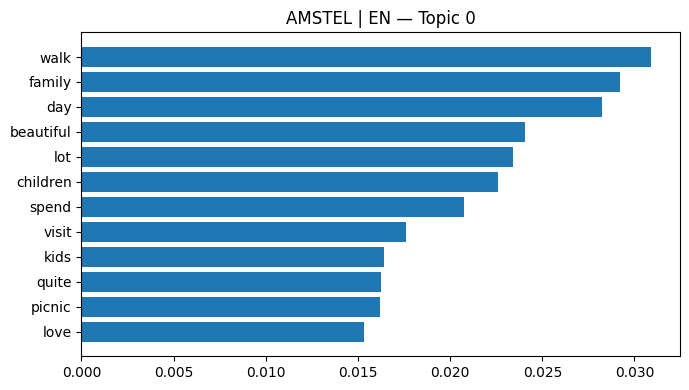

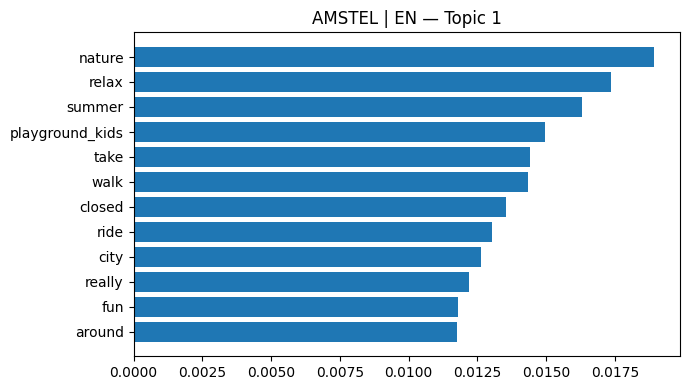

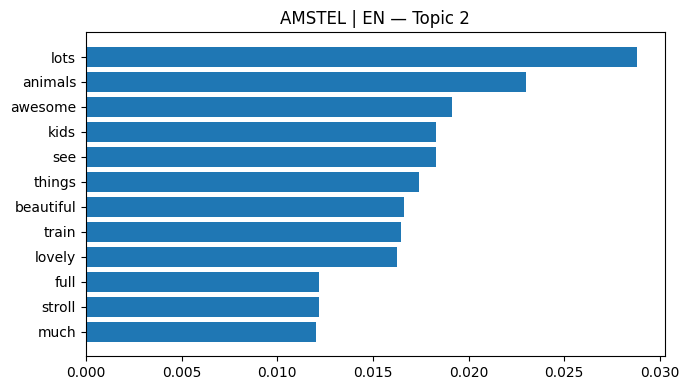

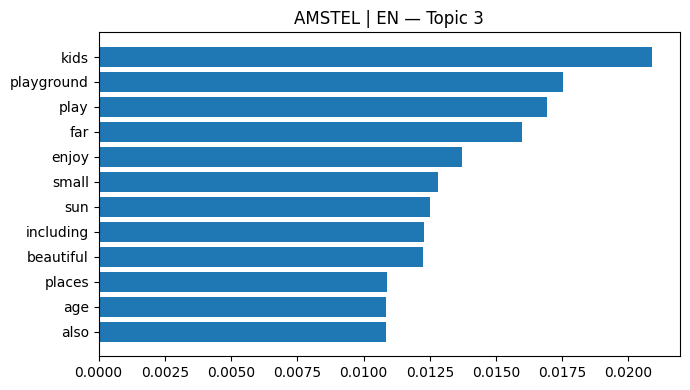

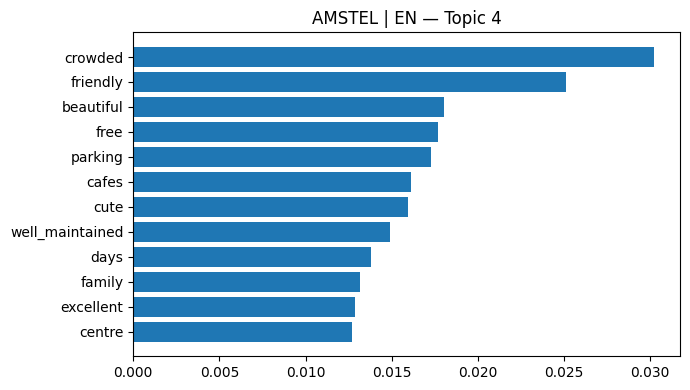

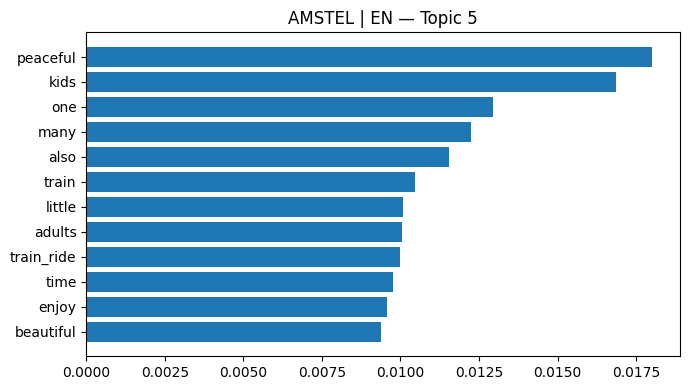


=== AMSTEL | NL | k=6 ===


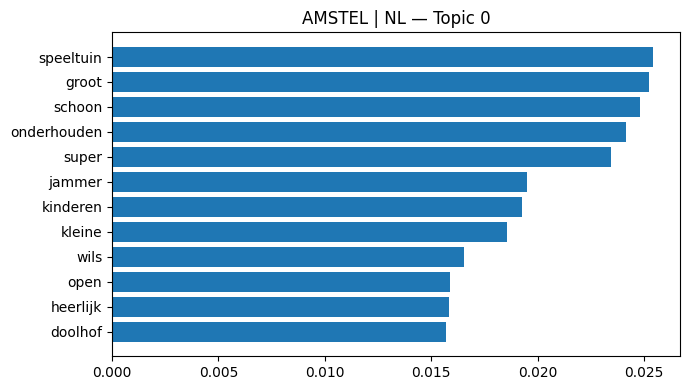

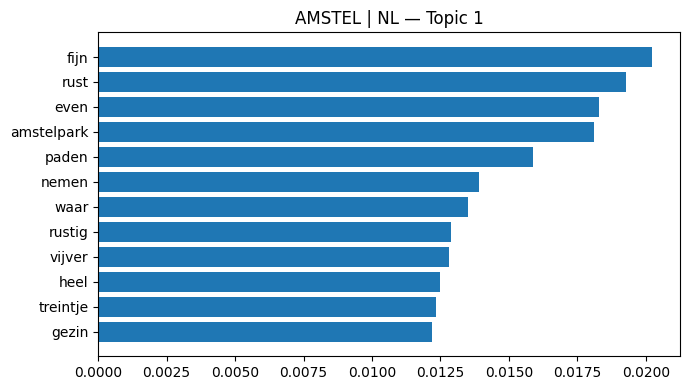

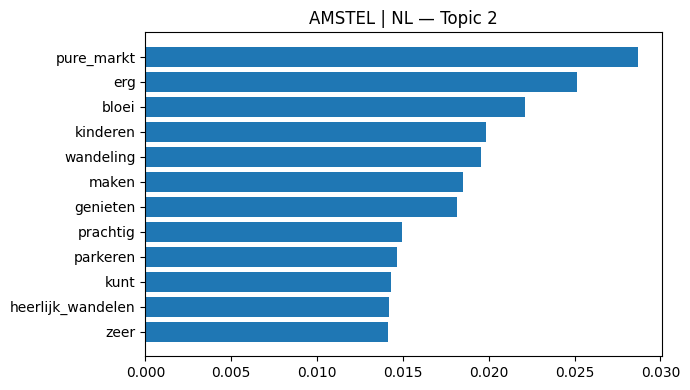

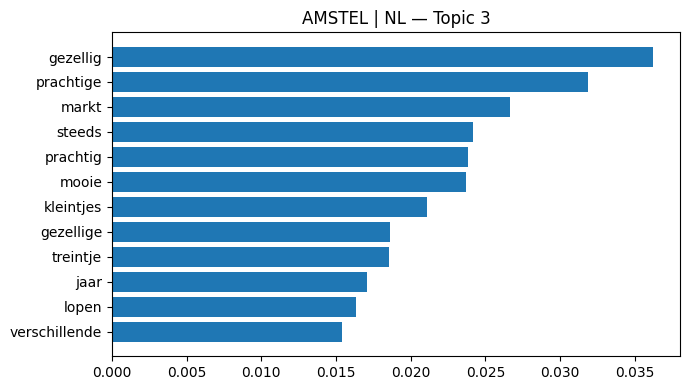

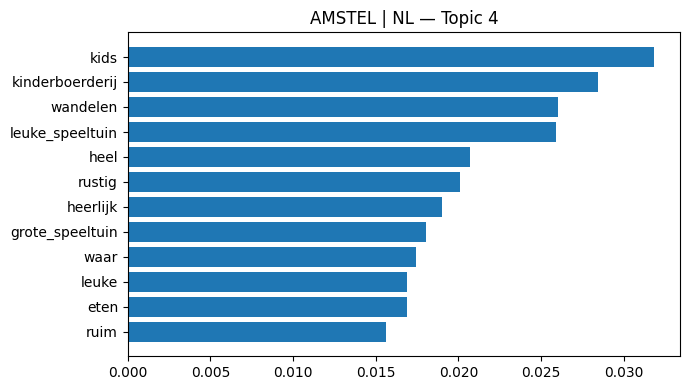

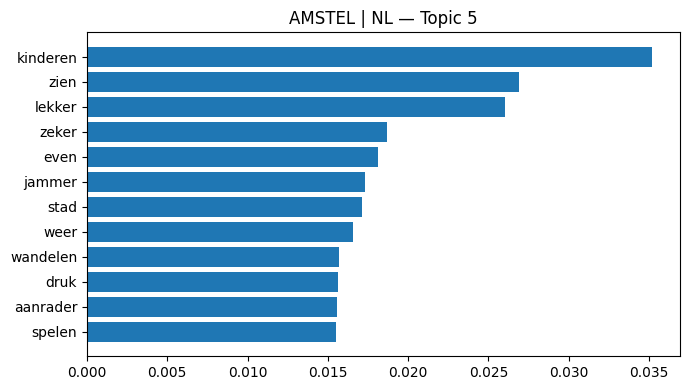


=== BEATRIX | EN | k=6 ===


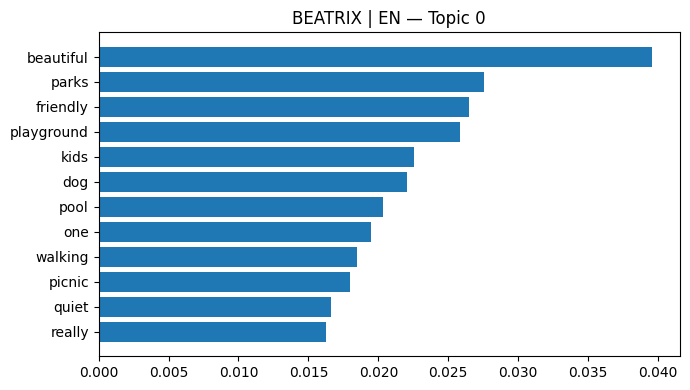

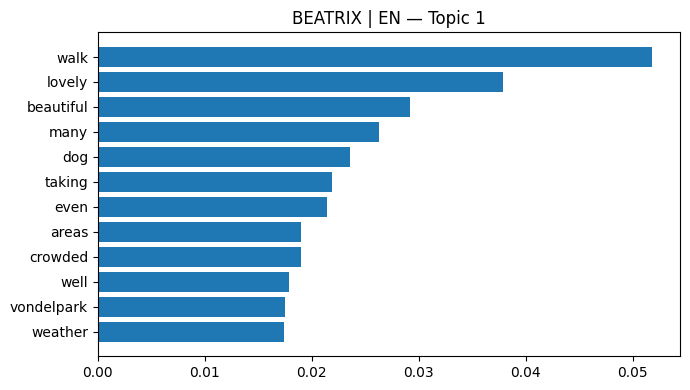

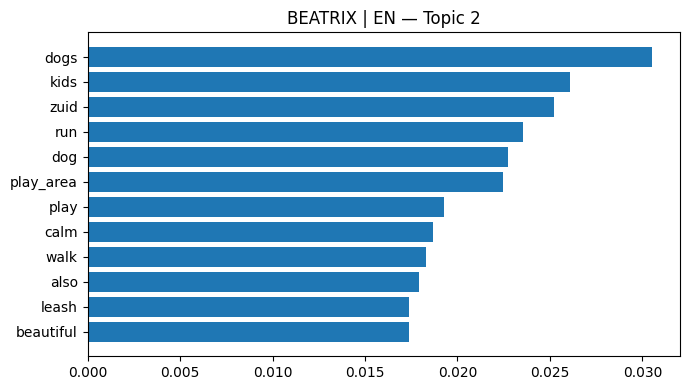

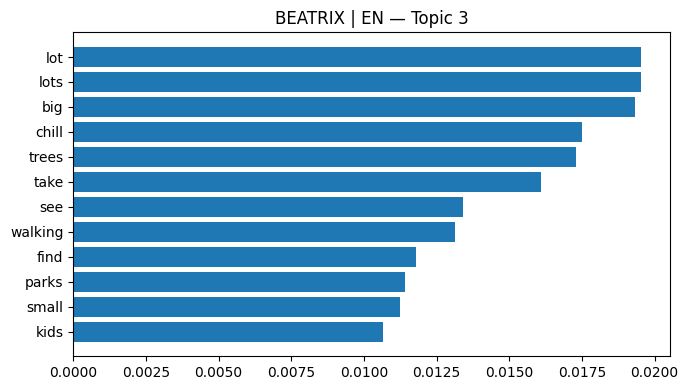

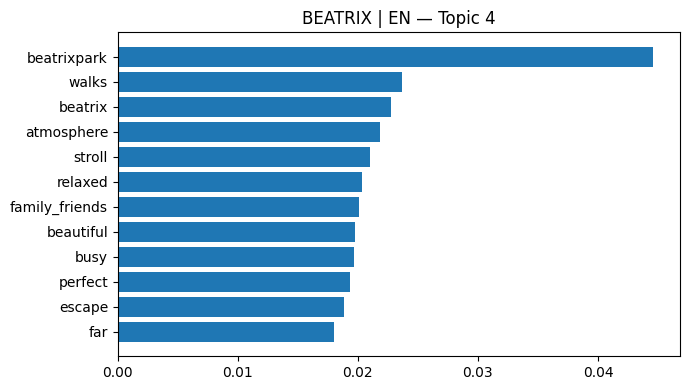

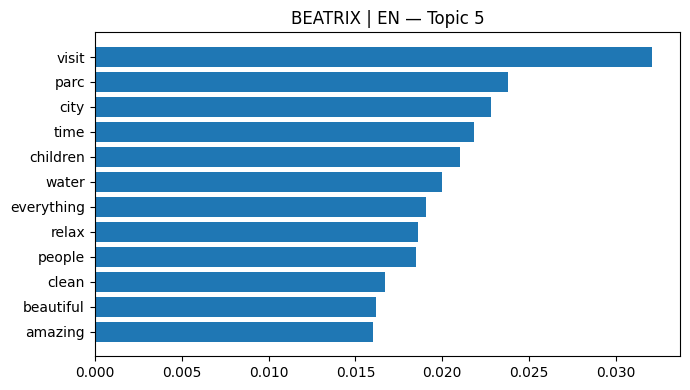


=== BEATRIX | NL | k=6 ===


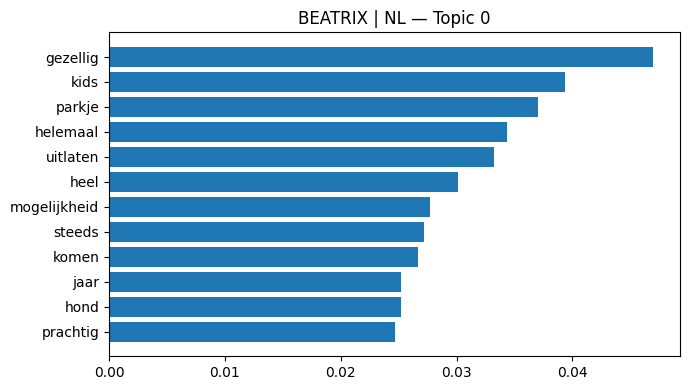

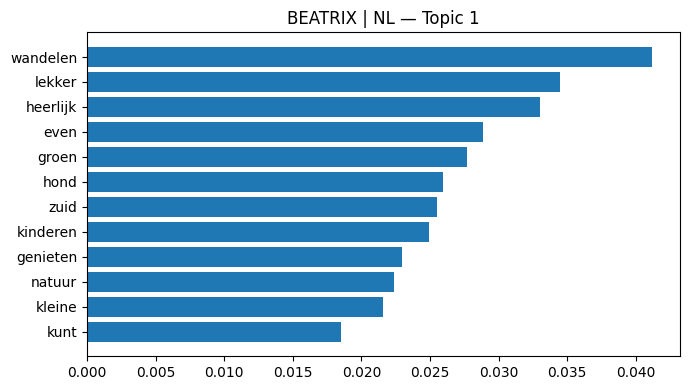

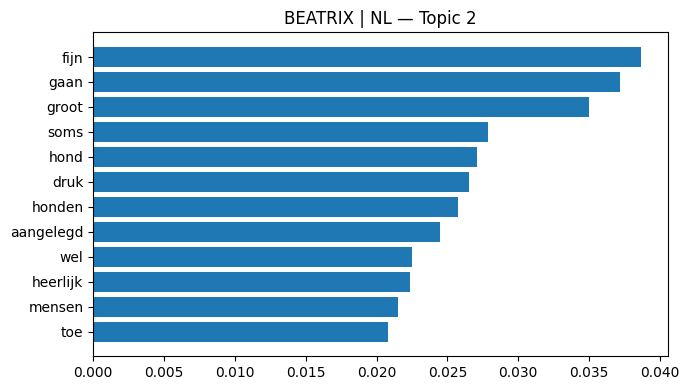

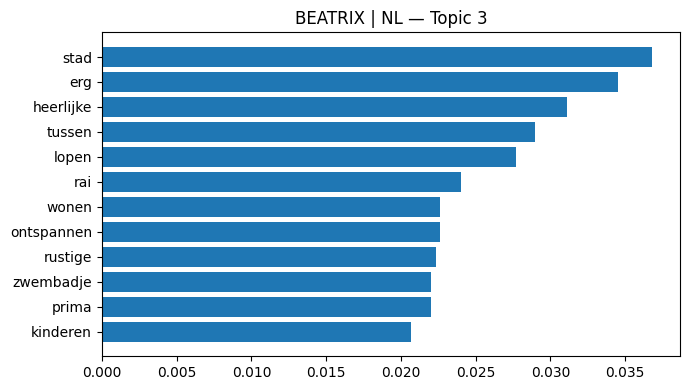

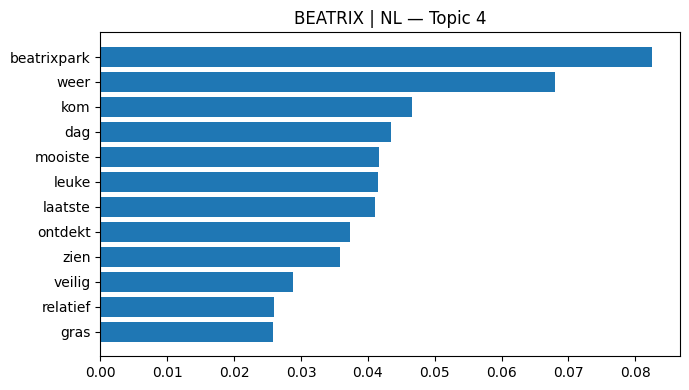

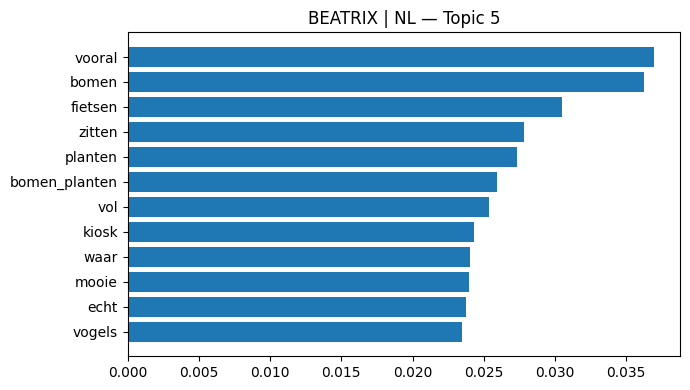


=== GAASPER | EN | k=6 ===


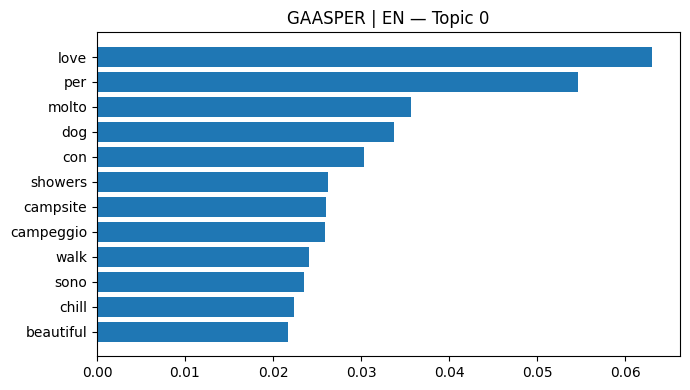

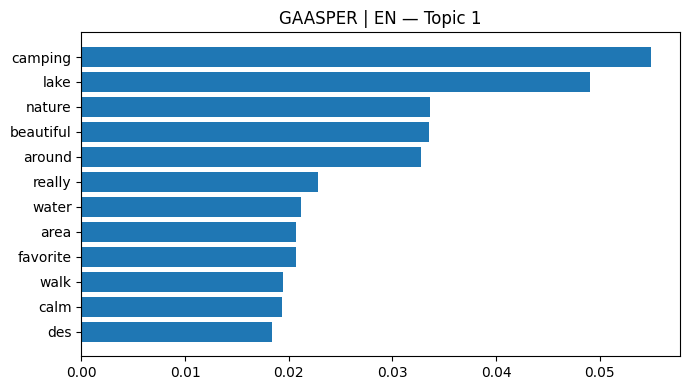

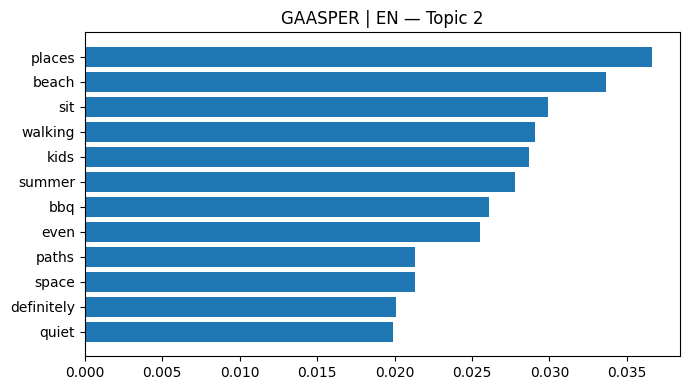

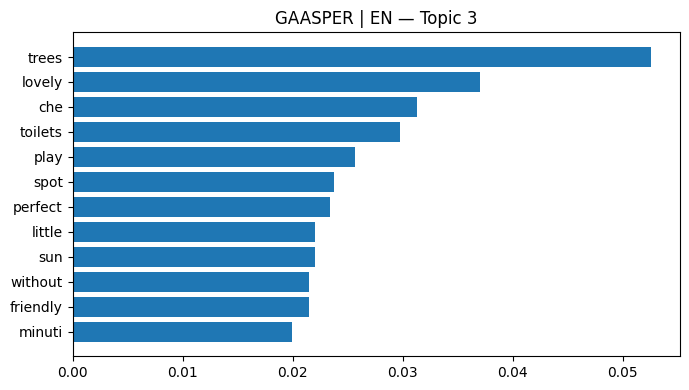

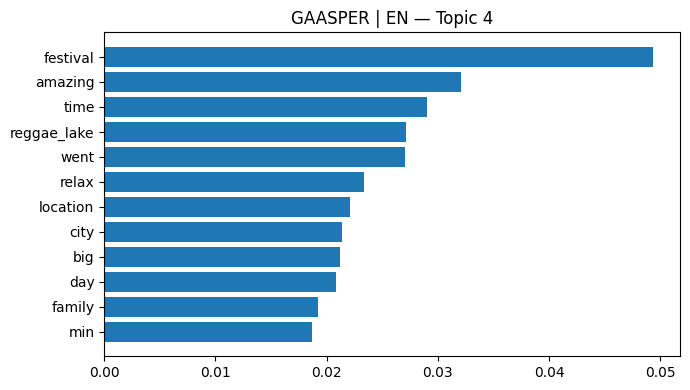

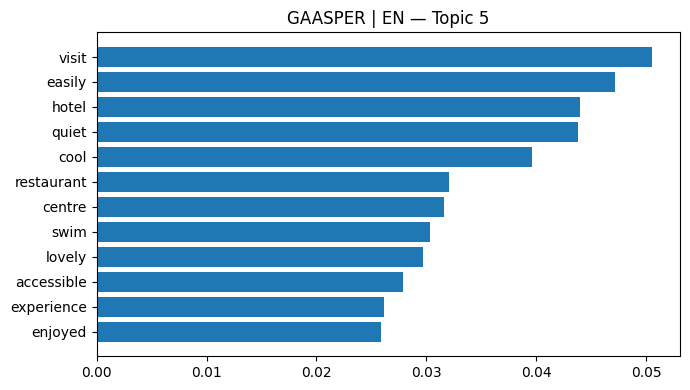


=== GAASPER | NL | k=6 ===


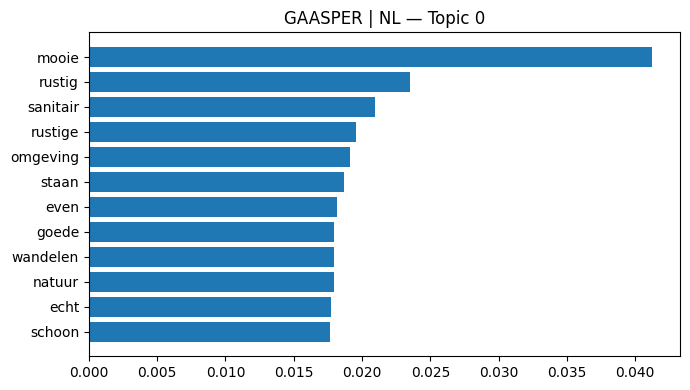

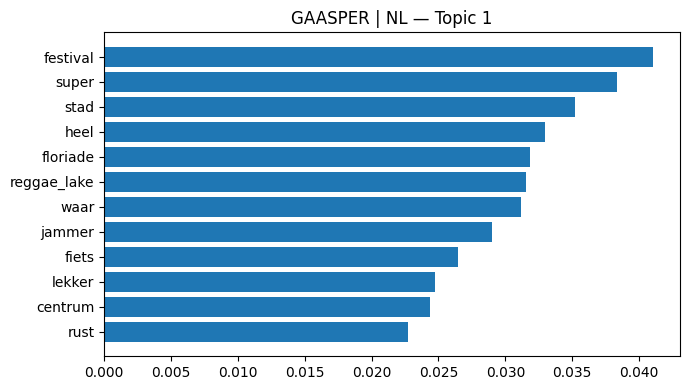

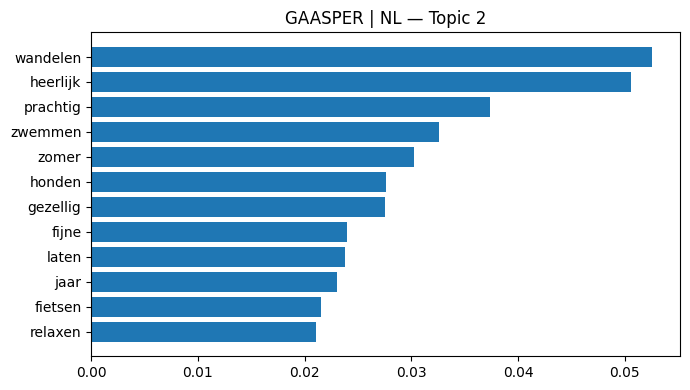

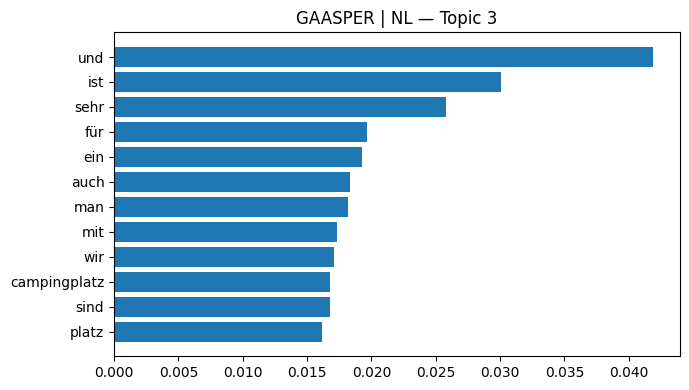

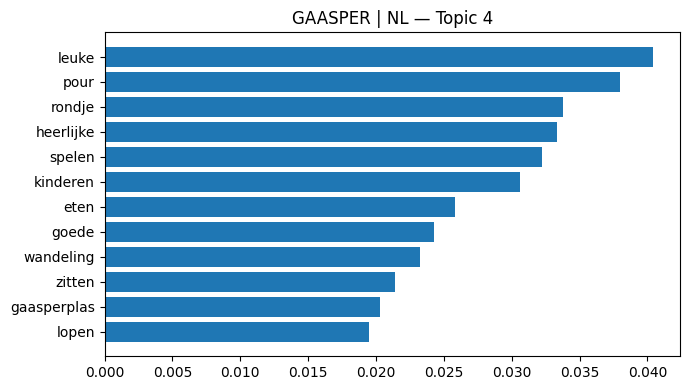

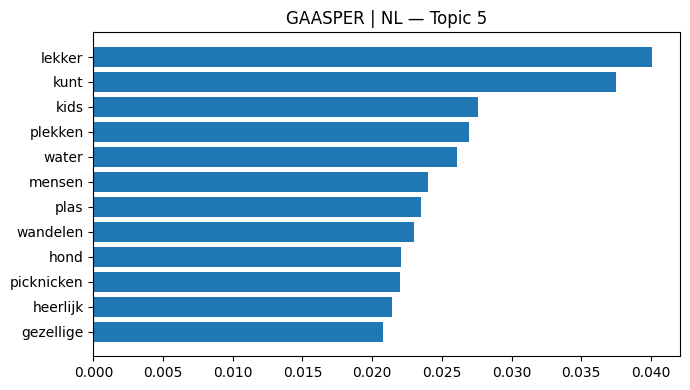


=== NELSON | EN | k=6 ===


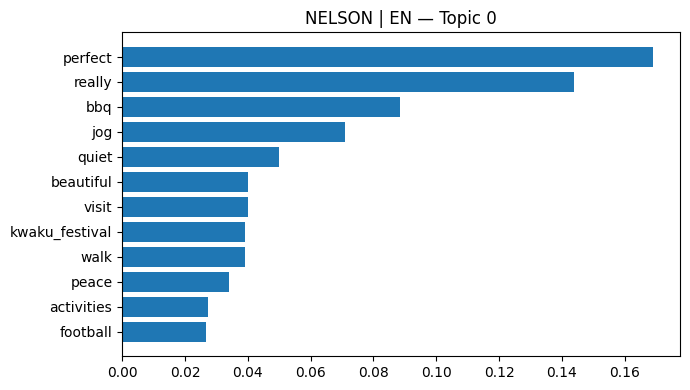

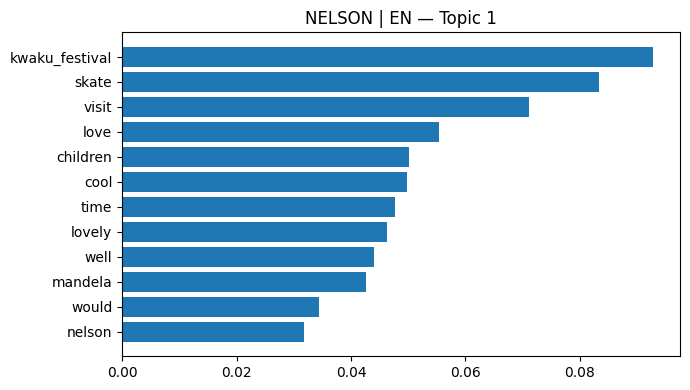

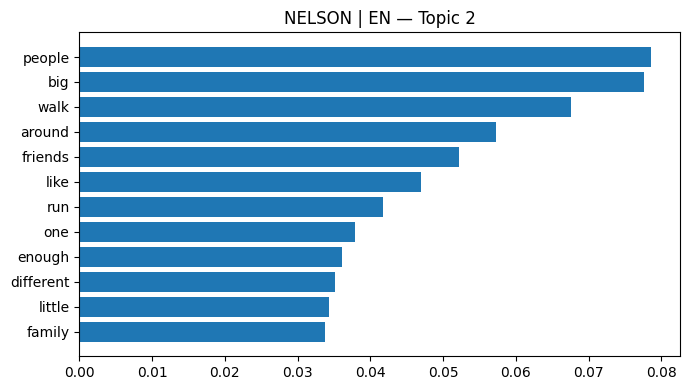

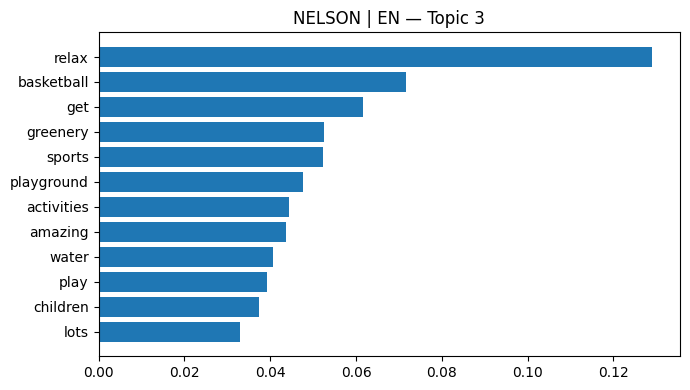

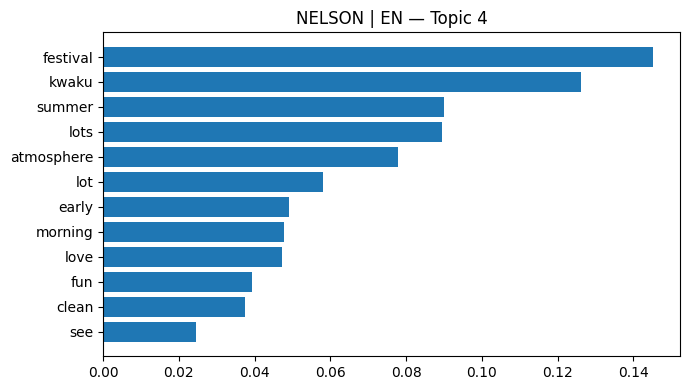

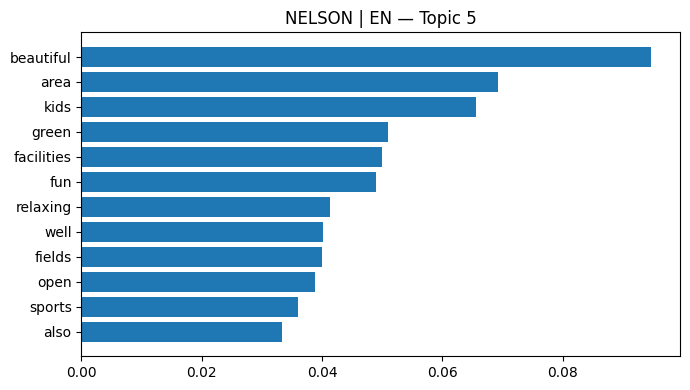


=== NELSON | NL | k=6 ===


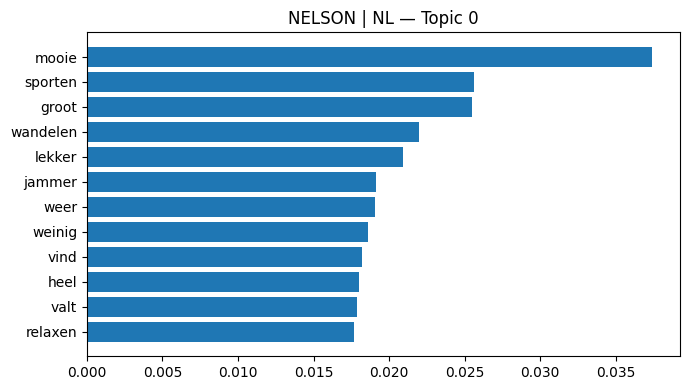

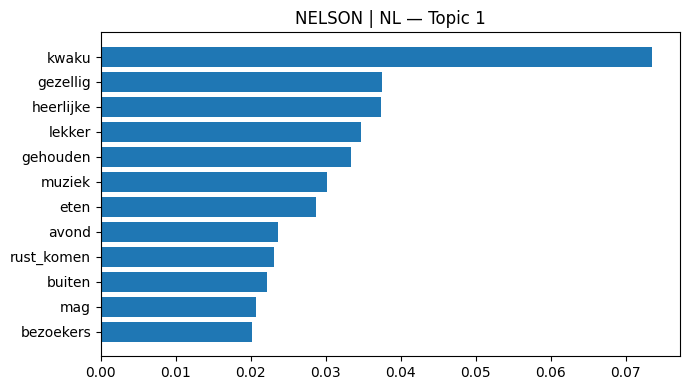

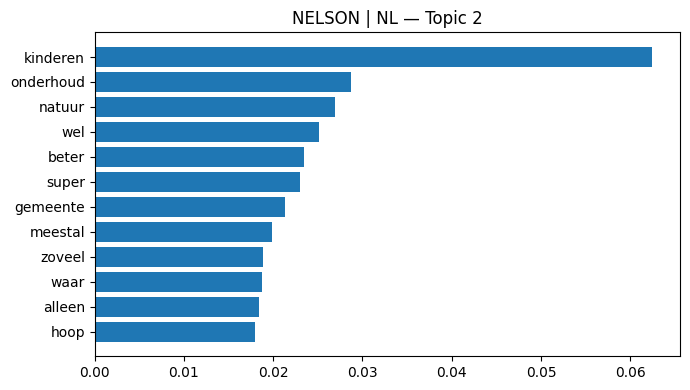

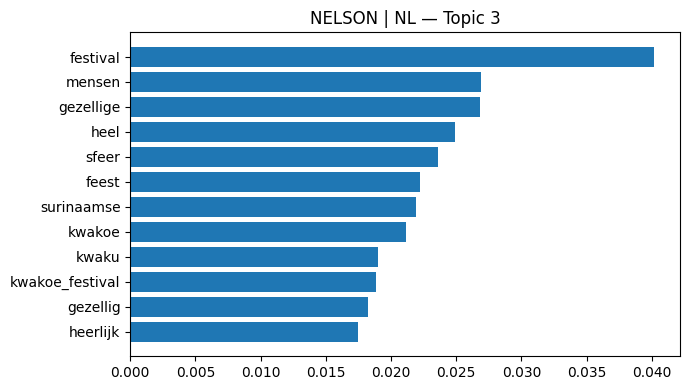

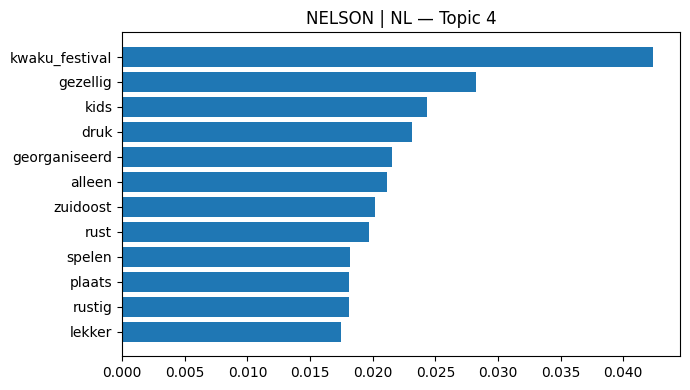

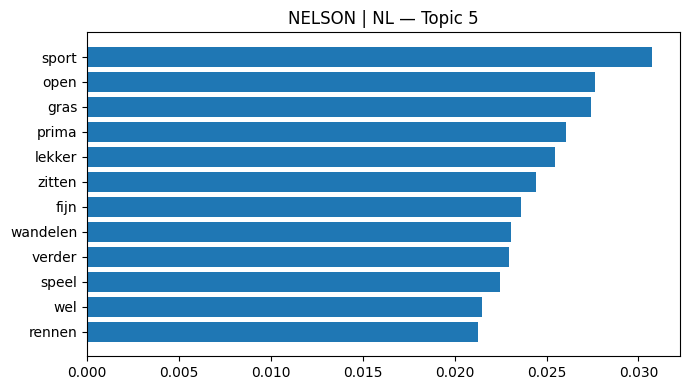

In [127]:
TOPN = 12

for (park_key, lang), obj in park_models.items():
    lda = obj["lda"]
    print(f"\n=== {park_key.upper()} | {lang.upper()} | k={lda.num_topics} ===")
    for tid in range(lda.num_topics):
        title = f"{park_key.upper()} | {lang.upper()} — Topic {tid}"
        plot_topic_words_bar(lda, tid, topn=TOPN, title=title)


In [128]:
def top_docs_per_topic(lda, corpus_bow, df_sub, topic_id, topn=3, text_col=TEXT_COL):
    scored = []
    for i, bow in enumerate(corpus_bow):
        prob = dict(lda.get_document_topics(bow, minimum_probability=0)).get(topic_id, 0.0)
        scored.append((i, prob))
    scored.sort(key=lambda x: x[1], reverse=True)

    out = []
    for i, p in scored[:topn]:
        out.append({
            "doc_idx": i,
            "topic_prob": float(p),
            "rating": df_sub.iloc[i].get("rating", None),
            "text": df_sub.iloc[i][text_col]
        })
    return pd.DataFrame(out)

TOP_DOCS = 3
TOP_TOPICS_PER_MODEL = 2

for (park_key, lang), obj in park_models.items():
    lda = obj["lda"]
    df_sub = obj["df"]
    corpus_bow = obj["corpus_bow"]

    mat = doc_topic_matrix(lda, corpus_bow, lda.num_topics)
    prev = mat.mean(axis=0)
    top_tids = list(np.argsort(prev)[::-1][:TOP_TOPICS_PER_MODEL])

    print(f"\n=== {park_key.upper()} | {lang.upper()} — top topics with example docs ===")
    for tid in top_tids:
        print("\nTopic", tid, ":", ", ".join([w for w,_ in lda.show_topic(tid, topn=10)]))
        display(top_docs_per_topic(lda, corpus_bow, df_sub, tid, topn=TOP_DOCS))



=== AMSTEL | EN — top topics with example docs ===

Topic 2 : lots, animals, awesome, kids, see, things, beautiful, train, lovely, full


,doc_idx,topic_prob,rating,text
0,162,0.954558,4.0,So many great things for the kids to do! The p...
1,81,0.947464,4.0,Small but pretty park with random pheasants ro...
2,28,0.943041,5.0,Lovely large park with big playgrounds. Pettin...



Topic 5 : peaceful, kids, one, many, also, train, little, adults, train_ride, time


,doc_idx,topic_prob,rating,text
0,238,0.954504,5.0,A great park for families and Pokemon Go playe...
1,218,0.954490,5.0,Nice place for kids. There is a miniature trai...
2,45,0.947259,5.0,"Really serene place. Good for walks, beautiful..."



=== AMSTEL | NL — top topics with example docs ===

Topic 5 : kinderen, zien, lekker, zeker, even, jammer, stad, weer, wandelen, druk


,doc_idx,topic_prob,rating,text
0,171,0.944603,5.0,"Ja, het is ""mijn goed onderhouden voor- en ach..."
1,247,0.934327,4.0,Mooi park om eventjes tot rust te komen. Genoe...
2,41,0.909463,5.0,Om even de stad achter je te laten is dit een ...



Topic 2 : pure_markt, erg, bloei, kinderen, wandeling, maken, genieten, prachtig, parkeren, kunt


,doc_idx,topic_prob,rating,text
0,225,0.944908,5.0,Wat een leuk park is dit. Er is ontzettend vee...
1,167,0.944617,4.0,Prachtig park met een indrukwekkende hoeveelhe...
2,396,0.919860,4.0,Leuk park met attracties voor kinderen en zeer...



=== BEATRIX | EN — top topics with example docs ===

Topic 2 : dogs, kids, zuid, run, dog, play_area, play, calm, walk, also


,doc_idx,topic_prob,rating,text
0,81,0.962344,5.0,Loved this place on a sunny day. Kids play fre...
1,447,0.962344,5.0,Loved this place on a sunny day. Kids play fre...
2,491,0.959959,5.0,"Love this park. Unlike Westerpark/Vondelpark, ..."



Topic 3 : lot, lots, big, chill, trees, take, see, walking, find, parks


,doc_idx,topic_prob,rating,text
0,14,0.961913,5.0,This is a wonderful park in Amsterdam south. T...
1,376,0.961913,5.0,This is a wonderful park in Amsterdam south. T...
2,133,0.956797,4.0,"Great place for toddlers, small cafe to get ta..."



=== BEATRIX | NL — top topics with example docs ===

Topic 1 : wandelen, lekker, heerlijk, even, groen, hond, zuid, kinderen, genieten, natuur


,doc_idx,topic_prob,rating,text
0,145,0.940722,4.0,Kleine groene oase in de Rivierenbuurt aan de ...
1,14,0.940721,4.0,Kleine groene oase in de Rivierenbuurt aan de ...
2,189,0.940689,5.0,Leuk park vlakbij station Amsterdam Zuid. Goed...



Topic 2 : fijn, gaan, groot, soms, hond, druk, honden, aangelegd, wel, heerlijk


,doc_idx,topic_prob,rating,text
0,64,0.936511,5.0,"Prachtig stadspark. Niet super groot, maar pre..."
1,193,0.936509,5.0,"Prachtig stadspark. Niet super groot, maar pre..."
2,172,0.936451,4.0,Leuk pierenbadje. Wel zelf speelgoed meenemen....



=== GAASPER | EN — top topics with example docs ===

Topic 4 : festival, amazing, time, reggae_lake, went, relax, location, city, big, day


,doc_idx,topic_prob,rating,text
0,284,0.948218,5.0,Excellent clean facilities and grounds. Pay ex...
1,26,0.948214,5.0,Excellent clean facilities and grounds. Pay ex...
2,29,0.920487,4.0,Very wide and big RV parking near train statio...



Topic 1 : camping, lake, nature, beautiful, around, really, water, area, favorite, walk


,doc_idx,topic_prob,rating,text
0,33,0.928773,5.0,wonderful area to cycle through and enjoy calm...
1,290,0.928773,5.0,wonderful area to cycle through and enjoy calm...
2,97,0.902031,5.0,Beautiful park close to diemen and with the ch...



=== GAASPER | NL — top topics with example docs ===

Topic 0 : mooie, rustig, sanitair, rustige, omgeving, staan, even, goede, wandelen, natuur


,doc_idx,topic_prob,rating,text
0,131,0.958716,5.0,Ideale plek om te staan met de camper voor bez...
1,56,0.958715,5.0,Ideale plek om te staan met de camper voor bez...
2,174,0.939650,5.0,Een mooie en rustige park met veel spelvoorzie...



Topic 3 : und, ist, sehr, für, ein, auch, man, mit, wir, campingplatz


,doc_idx,topic_prob,rating,text
0,445,0.991741,5.0,Diesen Campingplatz am Rand von Amsterdam habe...
1,28,0.991740,5.0,Diesen Campingplatz am Rand von Amsterdam habe...
2,19,0.984029,4.0,Grosser gepflegter Campingplatz am Rande von A...



=== NELSON | EN — top topics with example docs ===

Topic 2 : people, big, walk, around, friends, like, run, one, enough, different


,doc_idx,topic_prob,rating,text
0,192,0.888318,5.0,Spacious park with enough facilities to accomm...
1,8,0.888311,5.0,Spacious park with enough facilities to accomm...
2,6,0.870304,5.0,"The ""Bronze Faces"" monument is a magnificent e..."



Topic 5 : beautiful, area, kids, green, facilities, fun, relaxing, well, fields, open


,doc_idx,topic_prob,rating,text
0,183,0.921140,5.0,A nice park for having some fun with fresh air...
1,1,0.921133,5.0,A nice park for having some fun with fresh air...
2,40,0.900389,5.0,Big park with fun games for children. It also ...



=== NELSON | NL — top topics with example docs ===

Topic 4 : kwaku_festival, gezellig, kids, druk, georganiseerd, alleen, zuidoost, rust, spelen, plaats


,doc_idx,topic_prob,rating,text
0,34,0.947311,4.0,Wat was het weer gezellig op kwaku. Echt een ...
1,289,0.947303,4.0,Wat was het weer gezellig op kwaku. Echt een ...
2,33,0.931386,4.0,"Geweldig terrein om te kunnen feesten,sporten ..."



Topic 3 : festival, mensen, gezellige, heel, sfeer, feest, surinaamse, kwakoe, kwaku, kwakoe_festival


,doc_idx,topic_prob,rating,text
0,47,0.941569,5.0,Na een mooi zomerweekend is het er vaak rommel...
1,302,0.941569,5.0,Na een mooi zomerweekend is het er vaak rommel...
2,137,0.936094,5.0,"Het was die dag dat ik er was, Kwaku-festival...."


Bertopic:

In [129]:
import pandas as pd
import numpy as np

from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

RATING_COL = "rating"
LOWER_RATED_MAX = 3

df_all = data_filt.dropna(subset=[TEXT_COL]).copy()
df_all[TEXT_COL] = df_all[TEXT_COL].astype(str)
texts_all = df_all[TEXT_COL].tolist()

df_low = data_filt.dropna(subset=[TEXT_COL, RATING_COL]).copy()
df_low[RATING_COL] = pd.to_numeric(df_low[RATING_COL], errors="coerce")
df_low = df_low[df_low[RATING_COL] <= LOWER_RATED_MAX].copy()
df_low[TEXT_COL] = df_low[TEXT_COL].astype(str)
texts_low = df_low[TEXT_COL].tolist()

print("all docs:", len(texts_all))
print("lower-rated docs:", len(texts_low))



all docs: 3766
lower-rated docs: 298


In [130]:

EXTRA = {
    # en
    "the","and","to","of","in","for","on","with","is","it","this","that","was","were",
    "be","been","are","as","at","by","from","or","an","a",
    # nl
    "het","de","een","en","van","voor","met","dat","die","er","om","te","op","in","aan","ook","maar"
}

STOP_COMBINED = set()
if "STOP_EN" in globals():
    STOP_COMBINED |= set(STOP_EN)
if "STOP_NL" in globals():
    STOP_COMBINED |= set(STOP_NL)
STOP_COMBINED |= EXTRA

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.6,
    ngram_range=(1,2),
    stop_words=list(STOP_COMBINED),
    token_pattern=r"(?u)\b[a-zA-ZÀ-ÿ]{3,}\b"  
)

svd = TruncatedSVD(n_components=100, random_state=42)




In [131]:
X_all = tfidf.fit_transform(texts_all)
emb_all = svd.fit_transform(X_all)

bt_all = BERTopic(embedding_model=None, language="multilingual", verbose=True)
topics_all, probs_all = bt_all.fit_transform(texts_all, emb_all)

data_bt_all = df_all.copy()
data_bt_all["bt_topic"] = topics_all

display(bt_all.get_topic_info().head(15))




2026-01-08 17:50:07,470 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-08 17:50:15,406 - BERTopic - Dimensionality - Completed ✓
2026-01-08 17:50:15,408 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-08 17:50:15,520 - BERTopic - Cluster - Completed ✓
2026-01-08 17:50:15,523 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-08 17:50:15,607 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,541,-1_and_for_to_with,"[and, for, to, with, in, nice, the, park, you,...","[It's probably my favorite park in Amsterdam, ..."
1,0,93,0_mooi_met_voor_kinderen,"[mooi, met, voor, kinderen, een, de, park, leu...",[Mooi aangelegd park. Honden mogen aangelijnd ...
2,1,80,1_train_mini_golf_around,"[train, mini, golf, around, zoo, the, and, rid...",[Great park located between RAI and Amstelveen...
3,2,64,2_lots_of_do_with,"[lots, of, do, with, activities, see, to, spac...","[Nice park lots to see and do, Beautiful park ..."
4,3,63,3_dog_owners_friendly_your,"[dog, owners, friendly, your, dogs, leash, wal...",[I live this park. It was so green and pretty ...
5,4,62,4_nature_the_enjoy_of,"[nature, the, enjoy, of, and, amstelpark, perf...",[Gaasperpark is a hidden gem that offers a per...
6,5,60,5_great_crowds_park_and,"[great, crowds, park, and, not, to, with, too,...",[Great park! Stumbled upon this gem randomly o...
7,6,58,6_well_maintained_clean_and,"[well, maintained, clean, and, very, kept, it,...","[Very nice campsite, clean and well maintained..."
8,7,53,7_prachtig_fietspaden_een_het,"[prachtig, fietspaden, een, het, de, zuid, en,...","[Prachtig park, een aantal jaar geleden helema..."
9,8,52,8_beautiful_here_weeds_which,"[beautiful, here, weeds, which, sections, spri...","[It's a beautiful park., This is a beautiful p..."


In [132]:
X_low = tfidf.transform(texts_low)
emb_low = svd.transform(X_low)

bt_low = BERTopic(embedding_model=None, language="multilingual", verbose=True)
topics_low, probs_low = bt_low.fit_transform(texts_low, emb_low)

data_bt_low = df_low.copy()
data_bt_low["bt_topic"] = topics_low

display(bt_low.get_topic_info().head(15))


2026-01-08 17:50:15,821 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-08 17:50:15,968 - BERTopic - Dimensionality - Completed ✓
2026-01-08 17:50:15,970 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-08 17:50:15,980 - BERTopic - Cluster - Completed ✓
2026-01-08 17:50:15,982 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-08 17:50:16,004 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,36,-1_der_sehr_ist_und,"[der, sehr, ist, und, nicht, leider, des, et, ...",[Der Park ist schön angelegt. Die Bäume hoch g...
1,0,106,0_the_and_to_for,"[the, and, to, for, park, of, is, it, you, but]","[Great campsite for metro trip into Amsterdam,..."
2,1,37,1_te_het_erg_wel,"[te, het, erg, wel, is, en, er, de, niet, maar]","[Er is in de loop der jaren veel veranderd, ma..."
3,2,36,2_mooi_de_park_en,"[mooi, de, park, en, het, een, lekker, weer, i...",[ik heb het Beatrixpark altijd het mooiste par...
4,3,26,3_bomen_open_de_weinig,"[bomen, open, de, weinig, veel, er, meer, te, ...",[Park ligt helaas voor een deel nog steeds in ...
5,4,22,4_alleen_te_er_ben,"[alleen, te, er, ben, 15, ik, het, in, park, g...",[Het si ee leuk groot park alleen er zijn te v...
6,5,22,5_een_kinderen_goed_voor,"[een, kinderen, goed, voor, waar, en, er, het,...",[Mooi groot park waar je heerlijk kunt wandele...
7,6,13,6_festival_kwaku_het_en,"[festival, kwaku, het, en, 50, kost, de, niet,...",[Kwaku festival helaas maar 4 weken en inmidde...


In [133]:
def make_topic_labels(bt_model, topn=5):
    labels = {}
    info = bt_model.get_topic_info()
    for t in info["Topic"].tolist():
        t = int(t)
        if t == -1:
            labels[t] = "outliers"
        else:
            words = bt_model.get_topic(t) or []
            labels[t] = ", ".join([w for w,_ in words[:topn]])
    return labels, info

labels_all, info_all = make_topic_labels(bt_all, topn=5)
labels_low, info_low = make_topic_labels(bt_low, topn=5)

data_bt_all2 = data_bt_all[data_bt_all["bt_topic"] != -1].copy()
data_bt_low2 = data_bt_low[data_bt_low["bt_topic"] != -1].copy()

print("all kept:", len(data_bt_all2), "/", len(data_bt_all))
print("low kept:", len(data_bt_low2), "/", len(data_bt_low))



all kept: 3225 / 3766
low kept: 262 / 298


In [134]:
def topic_shares(df, group_cols, labels):
    out = (df.groupby(group_cols)["bt_topic"]
             .value_counts(normalize=True)
             .rename("share")
             .reset_index()
             .sort_values(group_cols + ["share"], ascending=[True]*len(group_cols) + [False]))
    out["topic_label"] = out["bt_topic"].apply(lambda t: labels.get(int(t), str(t)))
    return out

def lift_table(df, group_col, labels):
    overall = df["bt_topic"].value_counts(normalize=True)
    rows = []
    for g, sub in df.groupby(group_col):
        share = sub["bt_topic"].value_counts(normalize=True)
        for t, s in share.items():
            base = overall.get(t, 1e-9)
            rows.append({
                group_col: g,
                "bt_topic": int(t),
                "topic_label": labels.get(int(t), str(t)),
                "share": float(s),
                "overall": float(base),
                "lift": float(s/base),
            })
    return pd.DataFrame(rows).sort_values("lift", ascending=False)

print("all: lift by district")
display(lift_table(data_bt_all2, "district", labels_all).head(20))

print("all: shares by district, lang")
display(topic_shares(data_bt_all2, ["district","lang"], labels_all).head(30))

print("all: lift by park")
display(lift_table(data_bt_all2, "park_key", labels_all).head(30))

print("lower-rated: lift by district")
display(lift_table(data_bt_low2, "district", labels_low).head(20))


all: lift by district


,district,bt_topic,topic_label,share,overall,lift
141,Zuidoost,94,"minut, sprchy, na, ve, bohatě",0.011261,0.004651,2.421171
114,Zuidoost,21,"und, der, ist, sehr, campingplatz",0.030030,0.012403,2.421171
112,Zuidoost,15,"kwaku, festival, kost, optreden, was",0.032282,0.013333,2.421171
134,Zuidoost,87,"kwakoe, festival, ehbo, beroemde, politie",0.012763,0.005271,2.421171
154,Zuidoost,106,"kwaku, geweest, jaren, naar, belachelijk",0.009009,0.003721,2.421171
151,Zuidoost,110,"gezellige, mensen, dj, eten, was",0.009009,0.003721,2.421171
115,Zuidoost,16,"camping, sanitair, metro, centrum, bezoek",0.030030,0.013023,2.305877
127,Zuidoost,77,"festival, weekenden, omdat, praça, bairro",0.013514,0.005891,2.293741
116,Zuidoost,25,"reggae, lake, festival, was, went",0.026276,0.011473,2.290297
168,Zuidoost,113,"kwaku, weer, eten, lekker, muziek",0.007508,0.003411,2.201065


all: shares by district, lang


,district,lang,bt_topic,share,topic_label
0,Zuid,en,1,0.070009,"train, mini, golf, around, zoo"
1,Zuid,en,2,0.050142,"lots, of, do, with, activities"
2,Zuid,en,3,0.050142,"dog, owners, friendly, your, dogs"
3,Zuid,en,4,0.047304,"nature, the, enjoy, of, and"
4,Zuid,en,5,0.041627,"great, crowds, park, and, not"
5,Zuid,en,8,0.039735,"beautiful, here, weeds, which, sections"
6,Zuid,en,6,0.032167,"well, maintained, clean, and, very"
7,Zuid,en,12,0.032167,"area, play, kids, for, with"
8,Zuid,en,13,0.032167,"quiet, lawns, very, relaxing, and"
9,Zuid,en,20,0.030274,"great, place, family, children, to"


all: lift by park


,park_key,bt_topic,topic_label,share,overall,lift
305,nelson,15,"kwaku, festival, kost, optreden, was",0.065152,0.013333,4.886364
311,nelson,87,"kwakoe, festival, ehbo, beroemde, politie",0.025758,0.005271,4.886364
320,nelson,106,"kwaku, geweest, jaren, naar, belachelijk",0.018182,0.003721,4.886364
206,gaasper,21,"und, der, ist, sehr, campingplatz",0.059524,0.012403,4.799107
325,nelson,113,"kwaku, weer, eten, lekker, muziek",0.015152,0.003411,4.442149
208,gaasper,25,"reggae, lake, festival, was, went",0.050595,0.011473,4.409990
207,gaasper,16,"camping, sanitair, metro, centrum, bezoek",0.055060,0.013023,4.227785
211,gaasper,70,"station, metro, close, into, mins",0.025298,0.006202,4.079241
326,nelson,110,"gezellige, mensen, dj, eten, was",0.015152,0.003721,4.071970
116,beatrix,80,"beatrixpark, the, after, romantic, who",0.022388,0.005581,4.011194


lower-rated: lift by district


,district,bt_topic,topic_label,share,overall,lift
11,Zuidoost,6,"festival, kwaku, het, en, 50",0.082803,0.049618,1.668790
9,Zuidoost,3,"bomen, open, de, weinig, veel",0.127389,0.099237,1.283684
3,Zuid,4,"alleen, te, er, ben, 15",0.104762,0.083969,1.247619
0,Zuid,0,"the, and, to, for, park",0.495238,0.404580,1.224079
7,Zuidoost,2,"mooi, de, park, en, het",0.159236,0.137405,1.158882
1,Zuid,1,"te, het, erg, wel, is",0.161905,0.141221,1.146461
10,Zuidoost,5,"een, kinderen, goed, voor, waar",0.089172,0.083969,1.061957
4,Zuid,5,"een, kinderen, goed, voor, waar",0.076190,0.083969,0.907359
8,Zuidoost,1,"te, het, erg, wel, is",0.127389,0.141221,0.902049
6,Zuidoost,0,"the, and, to, for, park",0.343949,0.404580,0.850138


In [135]:
def sample_docs(df, topic_id, group_col=None, group_val=None, n=3, seed=42):
    sub = df[df["bt_topic"] == int(topic_id)]
    if group_col is not None and group_val is not None:
        sub = sub[sub[group_col] == group_val]
    if len(sub) == 0:
        return pd.DataFrame()
    cols = [c for c in ["park_key","district","lang","rating",TEXT_COL] if c in sub.columns]
    return sub.sample(min(n, len(sub)), random_state=seed)[cols]

# example zuidoost in all
lift_all_dist = lift_table(data_bt_all2, "district", labels_all)
top_zuidoost = lift_all_dist[lift_all_dist["district"]=="Zuidoost"].iloc[0]["bt_topic"]
print("top zuidoost topic:", int(top_zuidoost), "|", labels_all.get(int(top_zuidoost)))

display(sample_docs(data_bt_all2, top_zuidoost, "district", "Zuidoost", n=3))
display(sample_docs(data_bt_all2, top_zuidoost, "district", "Zuid", n=3))



top zuidoost topic: 94 | minut, sprchy, na, ve, bohatě


,park_key,district,lang,rating,text
4592,gaasper,Zuidoost,en,4.0,Dobré místo akorát jsem měli smůlu na noční pá...
4996,nelson,Zuidoost,en,3.0,It's was ok
3638,gaasper,Zuidoost,en,5.0,Čistý a klidný kemp. Občas klid naruší proléta...


""


In [136]:
import plotly.io as pio
pio.renderers.default = "vscode" 

bt_all.visualize_barchart(top_n_topics=12).show()
bt_all.visualize_topics().show()
